# Modeltraining

In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path("..") / "02_src"))

In [2]:
# ----------------------------------
# IMPORTS
#-----------------------------------

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

from sklearn.model_selection import train_test_split, GroupShuffleSplit, GroupKFold, StratifiedGroupKFold, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer, OneHotEncoder, FunctionTransformer, QuantileTransformer

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.impute import KNNImputer, SimpleImputer

from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score, mean_pinball_loss, make_scorer
import scipy.stats as stats

from sklearn.decomposition import PCA

from sklearn.inspection import permutation_importance

from sklearn import set_config
#set_config(transform_output="pandas")

In [3]:
# get main, clean prepared df 
from model_pipeline import data_preparation
df = data_preparation()

Quantile models saved


### Helper Visualization Functions

In [4]:
# ----------------------------------
# RESIDUAL PLOT
#-----------------------------------
def residual_plot(y_predicts, residuals, model):
    plt.figure(figsize=(10,4))
    sns.residplot(x=y_predicts, y=residuals, lowess=True, line_kws=dict(color="r"))
    plt.title(f"Residual-Plot for {model}")
    plt.xlabel("Predictions")
    plt.ylabel("Residuals (y_train - y_predicted)")
    plt.show()

def residuals_hist(residuals, model):
    plt.figure(figsize=(10,4))
    sns.histplot(residuals)
    plt.title(f"Resiudals Histogram for {model}")
    plt.show()

In [5]:
# -----------------------------------
# SCATTERPLOT PREDICTED VS REAL
#------------------------------------
def actual_vs_predicted(y_true, y_predicts, residuals, model):
    plt.figure(figsize=(10,4))
    ax = sns.scatterplot(x=y_true, y=y_predicts, hue=residuals)
    
    #plt.axline((0,0), slope=1) #https://stackoverflow.com/questions/22104256/does-matplotlib-have-a-function-for-drawing-diagonal-lines-in-axis-coordinates
    #ax.set_xlim(-10, y_true.max())
    #ax.set_ylim(-10, y_true.max())
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()])
    
    plt.title(f"Predicted vs Real Target for {model}")
    plt.ylabel("Predicted Target")
    plt.xlabel("Real Target")
    plt.show()

# Q-Q Plot
def prob_plot(residuals):
    plt.figure(figsize=(10, 5))
    stats.probplot(residuals, plot=plt)
    plt.show()

In [6]:
# -----------------------------------
# METRIC SCORES FOR CV
#------------------------------------
def show_scores(grid, model):
    best_score = grid.best_score_ 
    best_idx = grid.best_index_
    cv_res = pd.DataFrame(grid.cv_results_)
    folds_num = 7

    best_estimator = pd.DataFrame(cv_res.loc[cv_res["mean_test_r2"] == best_score]).reset_index()
    
    print(f"\n------{model} CV SCORES--------")  
    print("\nR2:")
    print(f'''\nTrain Folds R2 Scores: {[round(cv_res[f"split{i}_train_r2"][best_idx], 2) for i in range(folds_num)]}
            \nMean Train R2 Score: {round(cv_res["mean_train_r2"][best_idx], 2)}
            \nTest Folds R2 Scores: {[round(cv_res[f"split{i}_test_r2"][best_idx], 2) for i in range(folds_num)]}
            \nMean Test R2 Score (best_score_): {round(cv_res["mean_test_r2"][best_idx], 2)})   
            \nStd Test R2 Score: {round(cv_res["std_test_r2"][best_idx], 2)}''') 
    print("\nMAE:")
    #print(f'MAE error in relation to mean target: {-round( (cv_res["mean_test_mae"][best_idx] / target_mean()) * 100, 2 )} %')
    print(f'''\nTrain Folds MAE Scores: {[-round(cv_res[f"split{i}_train_mae"][best_idx], 2) for i in range(folds_num)]}
            \nMean Train MAE Score: {-round(cv_res["mean_train_mae"][best_idx],2)}
            \nTest Folds MAE Scores: {[-round(cv_res[f"split{i}_test_mae"][best_idx], 2) for i in range(folds_num)]}
            \nMean Test MAE Score: {-round(cv_res["mean_test_mae"][best_idx],2)}
            \nStd Test MAE Score: {round(cv_res["std_test_mae"][best_idx], 2)}''') 
    print("\nRMSE:")
    print(f'''\nTrain Folds RMSE Scores: {[-round(cv_res[f"split{i}_train_rmse"][best_idx], 2) for i in range(folds_num)]}
            \nMean Train RMSE Score: {-round(cv_res["mean_train_rmse"][best_idx], 2)}
            \nTest Folds RMSE Scores: {[-round(cv_res[f"split{i}_test_rmse"][best_idx], 2) for i in range(folds_num)]}
            \nMean Test RMSE Score: {-round(cv_res["mean_test_rmse"][best_idx], 2)}
            \nStd Test MAE Score: {round(cv_res["std_test_rmse"][best_idx], 2)}''')
    print("-----------------------------------------\n")

metrics = {"r2": "r2", "mae": "neg_mean_absolute_error", "rmse": "neg_root_mean_squared_error"}

In [7]:
# -----------------------------------
# METRIC SCORES FOR HOLDOUT TESTSET
#------------------------------------
def holdout_test(model, Xtest):
    y_pred = model.predict(Xtest)
    MAE_test = mean_absolute_error(y_test, y_pred)
    R2_test  = r2_score(y_test, y_pred)
    RMSE_test = root_mean_squared_error(y_test, y_pred)
    print(f"----Holdout Testset: Final Metric Scores----\n MAE: {MAE_test}, R2: {R2_test}, RMSE: {RMSE_test}")  
    
    errors = np.abs(y_test - y_pred)
    print(np.percentile(errors, [50, 75, 90, 95]))         

### Variables & Train-Test Split

In [8]:
# ----------------------------------
# VARIABLES: Features, Target, Group
#-----------------------------------

y = df["child_mortality_igme"] #target
X = df.drop(columns=["Code", "Year", "child_mortality_igme"]) #features
group = df["Entity"]

num_variables = X.drop(columns=["Entity", "world_regions_wb", "world_income_group"]).columns.to_list()
cat_variables = ["world_regions_wb", "world_income_group"]
regions_list = sorted(X["world_regions_wb"].dropna().unique())
incomegroups_list = sorted(X["world_income_group"].dropna().unique())

normal = ["years_of_schooling", "share_of_population_urban"]
others = ["vaccination_coverage_who_unicef"] #["years_of_schooling", "share_of_population_urban", "vaccination_coverage_who_unicef"] #leftskewed or normal-skewed vars
remove_nonskewed = normal + others

skewed_variables = num_variables.copy() #rightskewed vars
for el in remove_nonskewed:
    if el in skewed_variables:
        skewed_variables.remove(el)

world_regions = ["world_regions_wb"]
income_groups = ["world_income_group"]

#helper column names
col_country = "Entity"             
col_regions = "world_regions_wb"  
col_incomegroup = "world_income_group"
all_numeric_cols = skewed_variables + others + normal

col_healthspending = "annual_healthcare_expenditure_per_capita"
col_gdp = "gdp_per_capita_worldbank"
health_gdp =[] 

#all_numeric_cols

rest_nums = ["nurses_and_midwives_per_1000_people", "physicians_per_1000_people", "prevalence_of_undernourishment", "share_without_improved_water",
              "vaccination_coverage_who_unicef", "years_of_schooling", "share_of_population_urban"]

In [9]:
# ----------------------------------
# Train/Test Split
#-----------------------------------

gs_split = GroupShuffleSplit(n_splits=1, train_size=0.8, test_size=0.2, random_state=99)
train_index, test_index = next(gs_split.split(X, y, group))

X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]
group_train = group.iloc[train_index]
group_test  = group.iloc[test_index]

### Kmeans Cluster

In [113]:
# -------------------------------------
# KMeans Cluster outside of Pipeline
#--------------------------------------

X_train_cluster = X_train[num_variables].copy()

kmeans_rscaler = RobustScaler()
X_kmeans_scaled = kmeans_rscaler.fit_transform(X_train_cluster)

knn_impute = KNNImputer(n_neighbors=5, weights="distance")
X_kmeans_imputed = knn_impute.fit_transform(X_kmeans_scaled)

km_train = KMeans(n_clusters=6, random_state=99)
km_train.fit(X_kmeans_imputed)

km_dist_train = km_train.transform(X_kmeans_imputed)

km_distcols = [f"kmeans_dist_{i}" for i in range(km_dist_train.shape[1])]
X_cl_train = X_train.copy()
X_cl_train[km_distcols] = km_dist_train

clusters_df = pd.DataFrame(km_dist_train, columns=km_distcols, index=X_cl_train.index)
#kmeans_cluster_columns = pd.concat([km_dist_train], axis=1)
#kmeans_cluster_cols = pd.DataFrame(km_dist_train, columns=km_distcols, index=X_cl_train.copy().index)

In [56]:
#Kmeans on Testset
X_holdout_testset = X_test[num_variables].copy()

X_test_df = X_holdout_testset.copy()
X_test_df_scaled = kmeans_rscaler.transform(X_test_df)  
X_test_df_imputed = knn_impute.transform(X_test_df_scaled)  
km_dist_test = km_train.transform(X_test_df_imputed)

km_test_distcols = [f"kmeans_dist_{i}" for i in range(km_dist_test.shape[1])]
X_cl_test = X_test.copy()
X_cl_test[km_test_distcols] = km_dist_test

#### Extreme Outliers vs Normal

In [205]:
q95 = np.quantile(y_train, 0.95)

norm_mask = y_train <= q95
extrem_mask = y_train > q95

X_train_norm = X_cl_train[norm_mask]
y_train_norm = y_train[norm_mask]
groups_train_norm = group_train[norm_mask]  

X_train_extrem = X_cl_train[extrem_mask]
y_train_extrem = y_train[extrem_mask]
groups_train_extrem = group_train[extrem_mask]  

#### Visualize Cluster with PCA

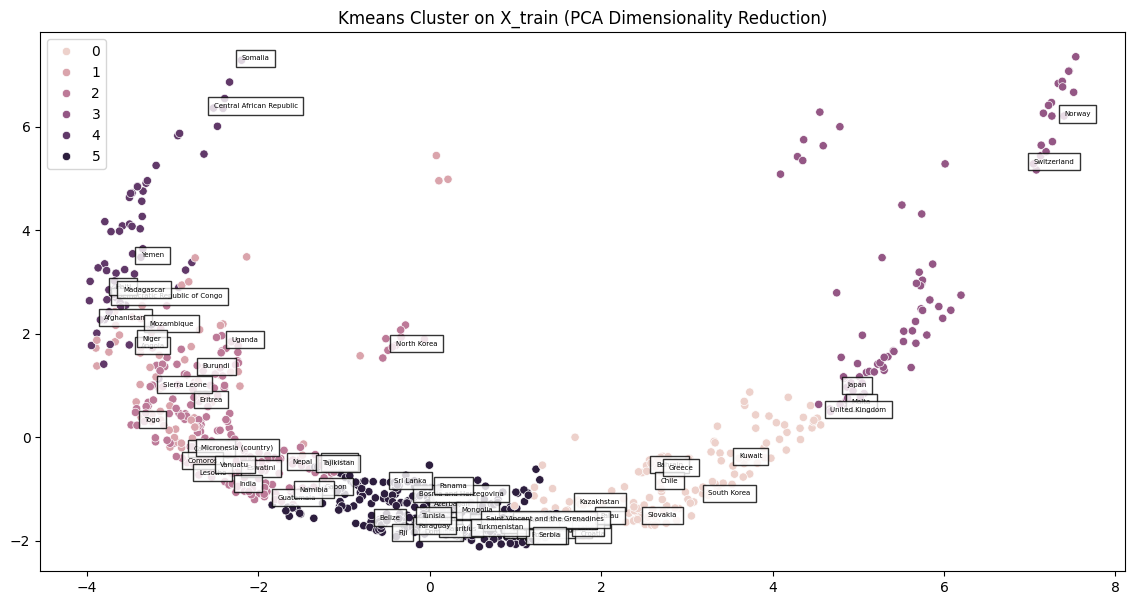

In [57]:
# ----------------------------------
# Visualize Cluster (PCA)
#-----------------------------------
df_imputed = pd.DataFrame(
    X_kmeans_imputed,
    columns=X_cl_train[num_variables].columns,  
    index=X_cl_train[num_variables].index      
)

X_cluster_pca = pd.concat([df_imputed, clusters_df], axis=1)
X_cluster_pca["Entity"] = X_cl_train["Entity"]
X_cluster_dist = X_cluster_pca[["kmeans_dist_0", "kmeans_dist_1", "kmeans_dist_2", "kmeans_dist_3", "kmeans_dist_4", "kmeans_dist_5"]]

clusters = X_cluster_dist.values.argmin(axis=1)

X_2d = PCA(n_components=2).fit_transform(X_cluster_dist)
plt.figure(figsize=(14, 7))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=clusters)

n=14
for i, c in enumerate(X_cluster_pca["Entity"]):
    if i % n == 0:
        plt.text(X_2d[i, 0], X_2d[i, 1], c, fontsize=5, bbox=dict(facecolor="white", alpha=0.8))
plt.title("Kmeans Cluster on X_train (PCA Dimensionality Reduction)")
plt.show()

### Within Information - Realtive to Countries Mean

In [10]:
# ----------------------------------
# CustomTransfomer: 
# create new within country columns
# relative to mean: (num_col value) - (mean num_col value per country)
#-----------------------------------
class RelativeToCountryMean(BaseEstimator, TransformerMixin):
    def __init__(self, country_col, num_cols):
        self.country_col = country_col
        self.num_cols = num_cols
        #self.order_name = f"{num_cols}_order"
        
    def fit(self, X, y=None):
        self.means_ = X.groupby(self.country_col)[self.num_cols].mean()
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.num_cols:
            mean_col = X[self.country_col].map(self.means_[col])
            #X[col] = X[self.country_col].map(self.means_[col])
            #X[f"{col}_mean"] = mean_col
            X[f"{col}_within"] = X[col] - mean_col
            #X[col] = X[col].fillna(X[col].mean())
            #print(X[col].isna().sum())
        return X

    #def get_feature_names_out(self, input_features=None):  
    #    new_features = input_features if input_features is not None else self.feature_names_in_
    #    names = list(new_features)
    #    for col in self.num_cols:
    #        out_names.append(f"{col}_within")
    #    return np.array(names, dtype=object)

In [11]:
def ratio_health_gdp(X):
    X = X.copy()
    X["healthspending_gdp_ratio"] = X["annual_healthcare_expenditure_per_capita"] - X["gdp_per_capita_worldbank"]
    return X

ratio_feature = FunctionTransformer(ratio_health_gdp, validate=False, feature_names_out=lambda transformer, input_features: ["gdp_per_capita_worldbank", "annual_healthcare_expenditure_per_capita", "healthspending_gdp_ratio"])

### Preprocessing Pipeline

In [12]:
# ----------------------------------
# Preprocessing Pipeline Steps
#-----------------------------------

#impute & transform numeric columns
impute_transform = ColumnTransformer([
    ("log_nums", Pipeline([
        ("knn_impute", KNNImputer(n_neighbors=5, weights="distance")),
        ("log_transform", FunctionTransformer(np.log1p, feature_names_out="one-to-one"))
    ]), skewed_variables),
    
    ("powertransform_nums", Pipeline([
        ("knn_impute2", KNNImputer(n_neighbors=5, weights="distance")),
        ("powertransform", PowerTransformer(method="yeo-johnson"))
    ]), others),
    
    ("normal_dist_nums", Pipeline([
        ("knn_impute3", KNNImputer(n_neighbors=5, weights="distance")),
    ]), normal),

    #("health_gdp_ratio", Pipeline([
    #    ("health_gdp_ratio", ratio_feature),
    #]), [col_gdp, col_healthspending])
        
], verbose_feature_names_out=False, remainder='passthrough').set_output(transform="pandas")

#ratio 
ratio_he_gdp = ColumnTransformer([
    ("health_gdp_ratio", Pipeline([
        ("health_gdp_ratio", ratio_feature),
    ]), [col_gdp, col_healthspending])
], verbose_feature_names_out=False, remainder="passthrough").set_output(transform="pandas")

#one hot encode pipeline for categoric cols
categorical_cols = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="constant", fill_value="missing")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

#Scale all num cols, ohe & drop country col
scale_ohe_step = ColumnTransformer([
    ("drop_nums", "drop", [col_gdp, col_healthspending]),
    ("scale_nums", RobustScaler(), rest_nums + ["healthspending_gdp_ratio"]),
    ("ohe_cat", categorical_cols, [col_regions, col_incomegroup]),
    ("drop_country", "drop", [col_country])
], verbose_feature_names_out=False, remainder="passthrough").set_output(transform="pandas")

#combine steps for model pipeline
end_pipe = Pipeline([
    ("prep_nums", impute_transform),
    ("ratio_feature", ratio_he_gdp),
    #("ratio_feature", ratio),
    #("relative_to_mean", RelativeToCountryMean(
    #    country_col=col_country, 
    #    num_cols=all_numeric_cols
    #)),
    #("transf_nums", nums_transf),
    ("scale_ohe", scale_ohe_step),
    ("final_impute", KNNImputer(n_neighbors=5, weights="distance")),
])

gk = GroupKFold(n_splits=7)

### Linear Regression (Baseline)

In [234]:
from sklearn.model_selection import cross_validate
# -------------------------------------------------
# BASELINE MODEL: LINEAR REGRESSION  NON-REGULARIZED
#--------------------------------------------------
lr_pipeline = Pipeline([
    ("preprocess", end_pipe),
    ("model", LinearRegression())
])

#qu_transformer = QuantileTransformer(output_distribution='normal', n_quantiles=100)
#Target is rightskewed, logtransform y before training
lr_pipeline_y_log = TransformedTargetRegressor(
    regressor=lr_pipeline,
    #transformer=qu_transformer
    func=np.log1p,
    inverse_func=np.expm1
)

lr_r2_cv = cross_val_score(lr_pipeline_y_log, X_train, y_train, groups=group_train, cv=gk, scoring="r2")
lr_mae_cv = cross_val_score(lr_pipeline_y_log, X_train, y_train, groups=group_train, cv=gk, scoring="neg_mean_absolute_error")
lr_rmse_cv = cross_val_score(lr_pipeline_y_log, X_train, y_train, groups=group_train, cv=gk, scoring="neg_root_mean_squared_error")
lr_r2_score = lr_r2_cv
lr_mae_score = -lr_mae_cv
lr_rmse_score = -lr_rmse_cv
# print crossvalidations scores (splitted into gk-folds (5), fit on gk - 1 & evaluate on last fold > iterate 5times)
print("\n------LINEAR REGRESSION CV SCORES--------")
print("\nR2:")
print(f"\nFolds R2 scores: {lr_r2_score}\nMean R2 Score: {round(lr_r2_score.mean(), 2)}\nStd R2: {round(lr_r2_score.std(), 2)}")
print("\nMAE:")
#print(f"MAE error in relation to mean target: {round( (lr_mae_score.mean() / target_mean()) * 100, 2 )} %")
print(f"\nFolds MAE scores: {lr_mae_score}\nMean MAE Score: {round(lr_mae_score.mean(), 2)}\nStd MAE: {round(lr_mae_score.std(), 2)}")
print("\nRMSE:")
print(f"\nFolds RMSE scores: {lr_rmse_score}\nMean RMSE Score: {round(lr_rmse_score.mean(), 2)}\nStd RMSE: {round(lr_rmse_score.std(), 2)}\n")
print("-----------------------------------------\n")


lr_cv_results = cross_validate(
    estimator=lr_pipeline_y_log,
    X=X_train,
    y=y_train,
    groups=group_train,          
    cv=gk,
    scoring=metrics,
    return_train_score=True,
    return_estimator=True
)
print(f'Train r2 mean: {lr_cv_results["train_r2"].mean()}, Train mae mean: {-lr_cv_results["train_mae"].mean()}, Train rmse mean: {-lr_cv_results["train_rmse"].mean()}')


------LINEAR REGRESSION CV SCORES--------

R2:

Folds R2 scores: [0.6433411  0.88702389 0.72104593 0.53159591 0.69553076 0.8465629
 0.84486899]
Mean R2 Score: 0.74
Std R2: 0.12

MAE:

Folds MAE scores: [10.26166935  6.77847523  9.52717018 16.63004231 11.43759143  8.95163618
 11.13714896]
Mean MAE Score: 10.67
Std MAE: 2.83

RMSE:

Folds RMSE scores: [14.60872491  9.21812505 13.68525512 31.74535838 17.03810371 15.28671635
 17.50547922]
Mean RMSE Score: 17.01
Std RMSE: 6.52

-----------------------------------------

Train r2 mean: 0.7867470669239173, Train mae mean: 9.079005644051989, Train rmse mean: 16.423003176303048


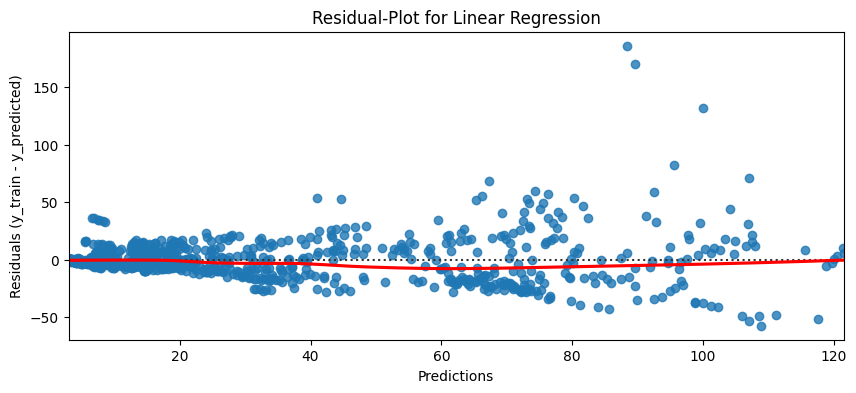

In [235]:
# -------------------------------------------------
# RESIDUAL PLOT FOR BASE MODEL: LINEAR REGRESSION NON-REGULARIZED
#--------------------------------------------------
lr_y_predicts = cross_val_predict(lr_pipeline_y_log, X_train, y_train, groups=group_train, cv=gk)
lr_residuals = y_train - lr_y_predicts

#lr_y_predicts = cross_val_predict(lr_pipeline_y_log, X_train_norm, y_train_norm, groups=groups_train_norm, cv=gk)
#lr_residuals = y_train_norm - lr_y_predicts

residual_plot(lr_y_predicts, lr_residuals, "Linear Regression")

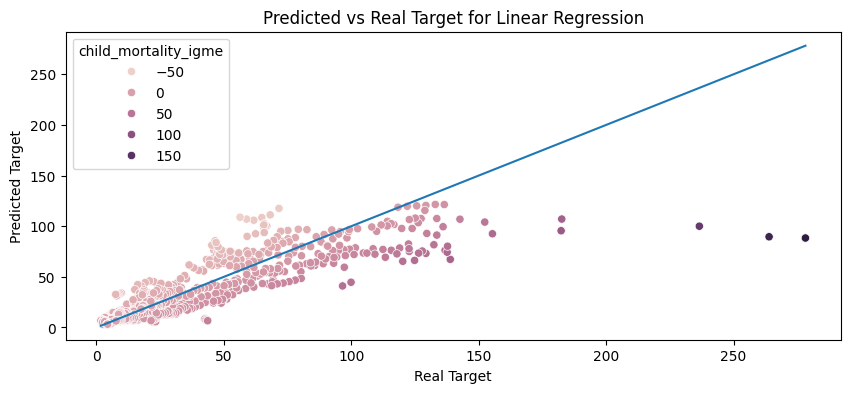

In [236]:
# -------------------------------------------------
# SCATTER PREDICED VS REAL FOR BASE MODEL: LINEAR REGRESSION NON-REGULARIZED
#--------------------------------------------------
actual_vs_predicted(y_train, lr_y_predicts, lr_residuals, "Linear Regression")
#actual_vs_predicted(y_train_norm, lr_y_predicts, lr_residuals, "Linear Regression")

In [237]:
#print all feature columns
first_fitted_estimatorlr = lr_cv_results['estimator'][0]
feature_pipelinelr = first_fitted_estimatorlr.regressor_
pre_pipelinelr = feature_pipelinelr.named_steps['preprocess']
last_transformerlr = pre_pipelinelr.steps[-1][1]
feature_names_finallr = last_transformerlr.get_feature_names_out()

print(f"Feature-Namen:")
print(feature_names_finallr)

Feature-Namen:
['nurses_and_midwives_per_1000_people' 'physicians_per_1000_people'
 'prevalence_of_undernourishment' 'share_without_improved_water'
 'vaccination_coverage_who_unicef' 'years_of_schooling'
 'share_of_population_urban' 'healthcare_gdp_ratio'
 'world_regions_wb_East Asia and Pacific (WB)'
 'world_regions_wb_Europe and Central Asia (WB)'
 'world_regions_wb_Latin America and Caribbean (WB)'
 'world_regions_wb_Middle East, North Africa, Afghanistan and Pakistan (WB)'
 'world_regions_wb_North America (WB)' 'world_regions_wb_South Asia (WB)'
 'world_regions_wb_Sub-Saharan Africa (WB)'
 'world_income_group_High-income countries'
 'world_income_group_Low-income countries'
 'world_income_group_Lower-middle-income countries'
 'world_income_group_Upper-middle-income countries'
 'world_income_group_missing']


#### Holdout Testset

In [238]:
lr_pipeline_y_log.fit(X_train, y_train)

holdout_test(lr_pipeline_y_log, X_test)  

----Holdout Testset: Final Metric Scores----
 MAE: 5.736234237978156, R2: 0.830598324955016, RMSE: 9.308899794962446
[ 2.14177017  9.10257979 14.76607064 19.1530493 ]


### Ridge

In [18]:
# -------------------------------------------------
# REGULARIZED LINEAR MODEL (RIDGE)
#--------------------------------------------------
ridge_pipeline = Pipeline([
    ("preprocess", end_pipe),
    ("model", Ridge())
])

#Target is rightskewed, logtransform y before training
ridge_pipeline_y_log  = TransformedTargetRegressor(
    regressor=ridge_pipeline,
    func=np.log1p,
    inverse_func=np.expm1
)

ridge_param_grid = {
    "regressor__model__alpha": [0.01, 0.1, 1, 10, 30, 40]
}
# fit trainset via GridSearchCV
ridge_grid = GridSearchCV(ridge_pipeline_y_log, ridge_param_grid, cv=gk, scoring=metrics, refit="mae", return_train_score=True, n_jobs=-1)
ridge_grid.fit(X_train, y_train, groups=group_train)
best_ridge_model = ridge_grid.best_estimator_
# print metrics scores
show_scores(ridge_grid, "Ridge")
ridge_grid.best_estimator_


------Ridge CV SCORES--------

R2:

Train Folds R2 Scores: [np.float64(0.77), np.float64(0.76), np.float64(0.77), np.float64(0.83), np.float64(0.77), np.float64(0.74), np.float64(0.74)]
            
Mean Train R2 Score: 0.77
            
Test Folds R2 Scores: [np.float64(0.67), np.float64(0.89), np.float64(0.78), np.float64(0.54), np.float64(0.66), np.float64(0.84), np.float64(0.83)]
            
Mean Test R2 Score (best_score_): 0.74)   
            
Std Test R2 Score: 0.12

MAE:

Train Folds MAE Scores: [np.float64(9.5), np.float64(9.89), np.float64(9.76), np.float64(8.57), np.float64(9.06), np.float64(9.76), np.float64(9.35)]
            
Mean Train MAE Score: 9.41
            
Test Folds MAE Scores: [np.float64(9.64), np.float64(6.74), np.float64(8.49), np.float64(16.3), np.float64(11.9), np.float64(8.64), np.float64(11.22)]
            
Mean Test MAE Score: 10.42
            
Std Test MAE Score: 2.89

RMSE:

Train Folds RMSE Scores: [np.float64(17.82), np.float64(18.01), np.float

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocess',
                                                      Pipeline(steps=[('prep_nums',
                                                                       ColumnTransformer(remainder='passthrough',
                                                                                         transformers=[('log_nums',
                                                                                                        Pipeline(steps=[('knn_impute',
                                                                                                                         KNNImputer(weights='distance')),
                                                                                                                        ('log_transform',
                                                                                                                         FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                                             func=<uf...
                                                                                                       ('ohe_cat',
                                                                                                        Pipeline(steps=[('imp',
                                                                                                                         SimpleImputer(fill_value='missing',
                                                                                                                                       strategy='constant')),
                                                                                                                        ('ohe',
                                                                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                                                                       sparse_output=False))]),
                                                                                                        ['world_regions_wb',
                                                                                                         'world_income_group']),
                                                                                                       ('drop_country',
                                                                                                        'drop',
                                                                                                        ['Entity'])],
                                                                                         verbose_feature_names_out=False)),
                                                                      ('final_impute',
                                                                       KNNImputer(weights='distance'))])),
                                                     ('model',
                                                      Ridge(alpha=40))]))

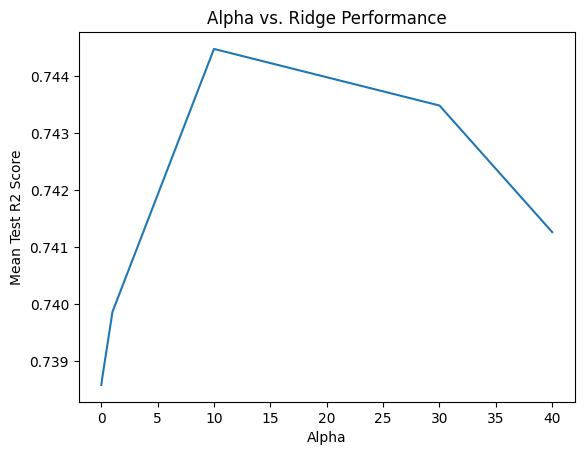

In [19]:
#show lineplot - best alpha - r2 score
ridge_results = pd.DataFrame(ridge_grid.cv_results_)
sns.lineplot(x=ridge_results['param_regressor__model__alpha'], y=ridge_results['mean_test_r2'])
plt.title("Alpha vs. Ridge Performance")
plt.xlabel("Alpha")
plt.ylabel("Mean Test R2 Score")
plt.show()

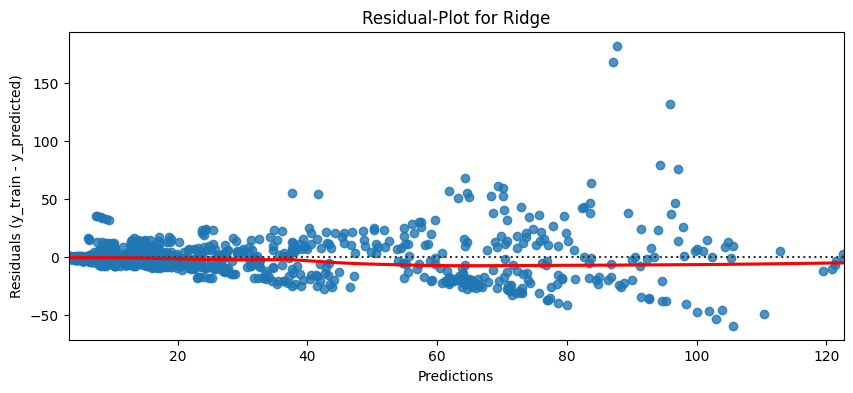

In [20]:
ridge_y_predicts = cross_val_predict(best_ridge_model, X_train, y_train, groups=group_train, cv=gk)
ridge_residuals = y_train - ridge_y_predicts

residual_plot(ridge_y_predicts, ridge_residuals, "Ridge")

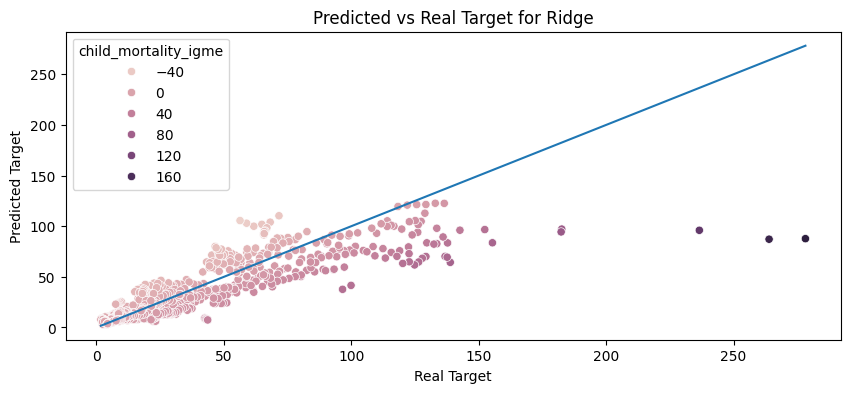

In [21]:
actual_vs_predicted(y_train, ridge_y_predicts, ridge_residuals, "Ridge")

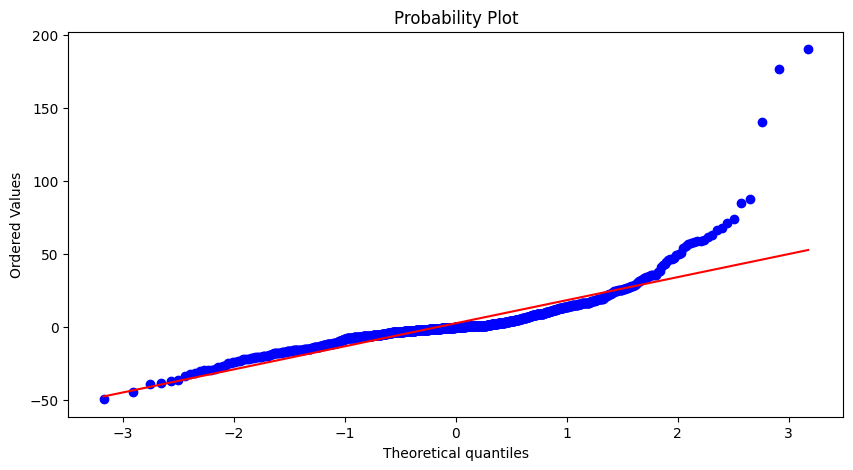

In [22]:
#prob. plot: shows heavy tails
prob_plot(ridge_residuals)

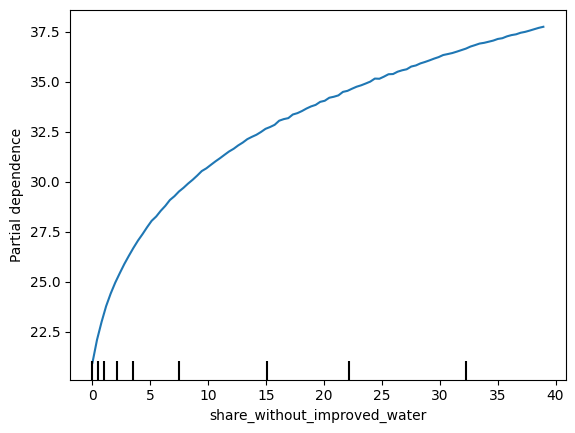

In [23]:
from sklearn.inspection import PartialDependenceDisplay
#prediction decreases when gdp_per_capita increases
#prediction decreases when vaccination_coverage increases
PartialDependenceDisplay.from_estimator(best_ridge_model, X_train, ["share_without_improved_water"])

#### Holdout Testset

In [24]:
#best_ridge_model.fit(X_train, y_train)

holdout_test(best_ridge_model, X_test)

----Holdout Testset: Final Metric Scores----
 MAE: 5.765372392068789, R2: 0.8320095363366209, RMSE: 9.270044514510838
[ 2.09735913  8.79782437 14.03347039 19.31867086]


In [247]:
ridge_feature_pipeline = best_ridge_model.regressor_
pre_pipeline_ridge = ridge_feature_pipeline.named_steps['preprocess']
last_transformer_ridge = pre_pipeline_ridge.steps[-1][1]
feature_names_final_ridge = last_transformer_ridge.get_feature_names_out()

In [248]:
pi_result_ridge = permutation_importance(best_ridge_model, X_test, y_test, n_repeats=10, random_state=42)
importance_df_ridge = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': np.round(pi_result_ridge.importances_mean, 4),
    'importance_std': np.round(pi_result_ridge.importances_std, 4)
}).sort_values(by='importance_mean', ascending=False)

importance_df_ridge

feature  importance_mean  importance_std
10                          world_regions_wb           0.2165          0.0284
7               share_without_improved_water           0.1860          0.0228
11                        world_income_group           0.1227          0.0238
9                         years_of_schooling           0.1220          0.0182
1   annual_healthcare_expenditure_per_capita           0.0915          0.0127
8            vaccination_coverage_who_unicef           0.0902          0.0107
3        nurses_and_midwives_per_1000_people           0.0806          0.0141
6                  share_of_population_urban           0.0488          0.0085
5             prevalence_of_undernourishment           0.0295          0.0099
0                                     Entity           0.0000          0.0000
4                 physicians_per_1000_people          -0.0065          0.0018
2                   gdp_per_capita_worldbank          -0.0226          0.0057

### ElasticNet

In [249]:
# -------------------------------------------------
# REGULARIZED LINEAR MODEL ELASTICNET
#--------------------------------------------------
elasticnet_pipeline = Pipeline([
    ("preprocess", end_pipe),
    ("model", ElasticNet(max_iter=5000, random_state=99))
])
#Target is rightskewed, logtransform y before training
elasticnet_pipeline_y_log = TransformedTargetRegressor(
    regressor=elasticnet_pipeline,
    func=np.log1p,
    inverse_func=np.expm1
)

elasticnet_param_grid = {
    "regressor__model__alpha": [0.01, 0.1, 1, 10, 30, 60, 90],
    "regressor__model__l1_ratio": [0.1, 0.2, 0.5, 0.8]
}

elasticnet_grid = GridSearchCV(elasticnet_pipeline_y_log, elasticnet_param_grid, cv=gk, scoring=metrics, refit="mae", return_train_score=True, n_jobs=-1)
elasticnet_grid.fit(X_train, y_train, groups=group_train)
best_elasticnet_model = elasticnet_grid.best_estimator_

show_scores(elasticnet_grid, "ElasticNet")

elasticnet_grid.best_estimator_
#pd.DataFrame(elasticnet_grid.cv_results_)


------ElasticNet CV SCORES--------

R2:

Train Folds R2 Scores: [np.float64(0.78), np.float64(0.76), np.float64(0.77), np.float64(0.83), np.float64(0.77), np.float64(0.74), np.float64(0.74)]
            
Mean Train R2 Score: 0.77
            
Test Folds R2 Scores: [np.float64(0.63), np.float64(0.89), np.float64(0.82), np.float64(0.53), np.float64(0.7), np.float64(0.85), np.float64(0.83)]
            
Mean Test R2 Score (best_score_): 0.75)   
            
Std Test R2 Score: 0.12

MAE:

Train Folds MAE Scores: [np.float64(9.2), np.float64(9.68), np.float64(9.76), np.float64(8.45), np.float64(8.98), np.float64(9.61), np.float64(9.16)]
            
Mean Train MAE Score: 9.26
            
Test Folds MAE Scores: [np.float64(10.2), np.float64(6.65), np.float64(7.88), np.float64(16.23), np.float64(11.28), np.float64(8.69), np.float64(11.12)]
            
Mean Test MAE Score: 10.29
            
Std Test MAE Score: 2.89

RMSE:

Train Folds RMSE Scores: [np.float64(17.53), np.float64(17.8), np.

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocess',
                                                      Pipeline(steps=[('prep_nums',
                                                                       ColumnTransformer(remainder='passthrough',
                                                                                         transformers=[('log_nums',
                                                                                                        Pipeline(steps=[('knn_impute',
                                                                                                                         KNNImputer(weights='distance')),
                                                                                                                        ('log_transform',
                                                                                                                         FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                                             func=<uf...
                                                                                                                         SimpleImputer(fill_value='missing',
                                                                                                                                       strategy='constant')),
                                                                                                                        ('ohe',
                                                                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                                                                       sparse_output=False))]),
                                                                                                        ['world_regions_wb',
                                                                                                         'world_income_group']),
                                                                                                       ('drop_country',
                                                                                                        'drop',
                                                                                                        ['Entity'])],
                                                                                         verbose_feature_names_out=False)),
                                                                      ('final_impute',
                                                                       KNNImputer(weights='distance'))])),
                                                     ('model',
                                                      ElasticNet(alpha=0.01,
                                                                 l1_ratio=0.8,
                                                                 max_iter=5000,
                                                                 random_state=99))]))

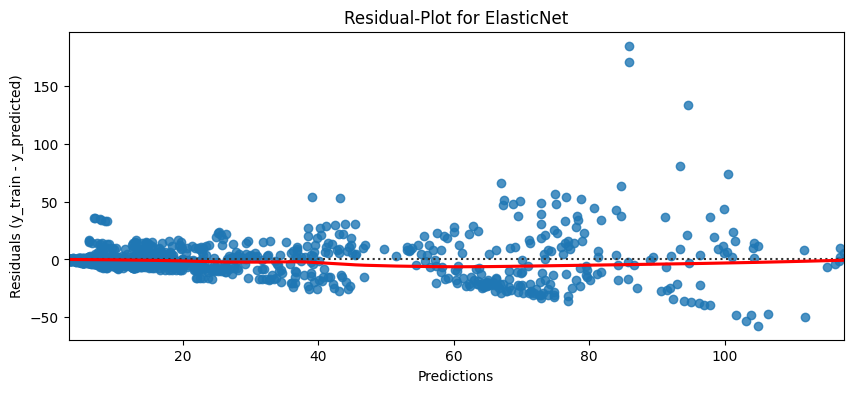

In [250]:
# -------------------------------------------------
# RESIDUAL PLOT FOR ELASTICNET
#--------------------------------------------------
elasticnet_y_predicts = cross_val_predict(best_elasticnet_model, X_train, y_train, groups=group_train, cv=gk)
elasticnet_residuals = y_train - elasticnet_y_predicts

residual_plot(elasticnet_y_predicts, elasticnet_residuals, "ElasticNet")

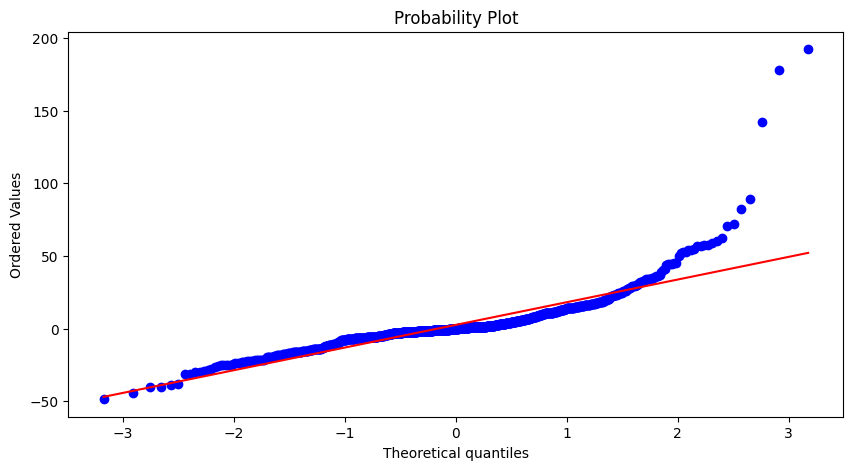

In [251]:
# -------------------------------------------------
# Quantile-Quantile-Plot OF RESIDUALS FOR ELASTICNET 
#--------------------------------------------------
prob_plot(elasticnet_residuals)

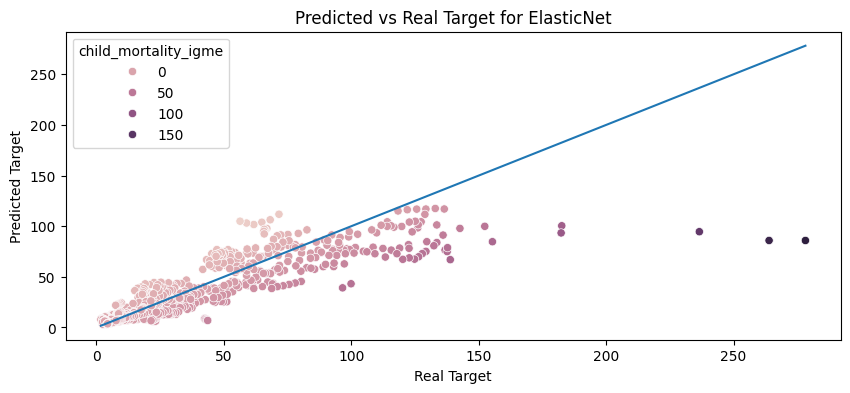

In [252]:
# -------------------------------------------------
# SCATTER PREDICED VS REAL FOR ELASTUCNET
#--------------------------------------------------
#actual_vs_predicted(y_train, elasticnet_y_predicts, elasticnet_residuals, "ElasticNet")
actual_vs_predicted(y_train, elasticnet_y_predicts, elasticnet_residuals, "ElasticNet")

In [85]:
pi_result_el = permutation_importance(best_elasticnet_model, X_test, y_test, n_repeats=40, random_state=42)
importance_df_el = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': np.round(pi_result_el.importances_mean, 4),
    'importance_std': np.round(pi_result_el.importances_std, 4)
}).sort_values(by='importance_mean', ascending=False)

importance_df_el

feature  importance_mean  importance_std
1   annual_healthcare_expenditure_per_capita           0.1783          0.0223
10                          world_regions_wb           0.1405          0.0164
7               share_without_improved_water           0.1165          0.0133
2                   gdp_per_capita_worldbank           0.1132          0.0163
9                         years_of_schooling           0.0813          0.0104
8            vaccination_coverage_who_unicef           0.0723          0.0104
3        nurses_and_midwives_per_1000_people           0.0710          0.0112
11                        world_income_group           0.0347          0.0081
5             prevalence_of_undernourishment           0.0187          0.0054
6                  share_of_population_urban           0.0135          0.0028
0                                     Entity           0.0000          0.0000
4                 physicians_per_1000_people          -0.0001          0.0004

#### Holdout Test

In [265]:
#best_elasticnet_model.fit(X_train, y_train)

holdout_test(best_elasticnet_model, X_test)

----Holdout Testset: Final Metric Scores----
 MAE: 5.504625837929027, R2: 0.8475568890968693, RMSE: 8.830664938172552
[ 2.16868586  8.85873595 14.15413791 18.36865269]


### Random Forest

In [254]:
# -------------------------------------------------
# RF
#--------------------------------------------------
rf_pipeline = Pipeline([
    ("preprocess", end_pipe),
    ("model", RandomForestRegressor(random_state=99))
])
#Target is rightskewed, logtransform y before training
rf_pipeline_y_log = TransformedTargetRegressor(
    regressor=rf_pipeline,
    func=np.log1p,
    inverse_func=np.expm1
)

rf_param_grid = {
    "regressor__model__n_estimators": [300, 500],
    "regressor__model__max_depth": [1, 3],
    "regressor__model__min_samples_split": [5, 15],
    "regressor__model__min_samples_leaf": [20, 30],
    "regressor__model__max_features": [0.2],
    "regressor__model__max_samples": [0.7, 0.8]
}

rf_grid = GridSearchCV(rf_pipeline_y_log, rf_param_grid, cv=gk, scoring=metrics, refit="mae", return_train_score=True, n_jobs=-1)
rf_grid.fit(X_train, y_train, groups=group_train)
best_rf_model = rf_grid.best_estimator_

show_scores(rf_grid, "RF")
rf_grid.best_estimator_


------RF CV SCORES--------

R2:

Train Folds R2 Scores: [np.float64(0.72), np.float64(0.66), np.float64(0.69), np.float64(0.72), np.float64(0.72), np.float64(0.67), np.float64(0.67)]
            
Mean Train R2 Score: 0.69
            
Test Folds R2 Scores: [np.float64(0.51), np.float64(0.8), np.float64(0.73), np.float64(0.45), np.float64(0.58), np.float64(0.73), np.float64(0.66)]
            
Mean Test R2 Score (best_score_): 0.64)   
            
Std Test R2 Score: 0.12

MAE:

Train Folds MAE Scores: [np.float64(10.15), np.float64(10.97), np.float64(10.65), np.float64(9.8), np.float64(9.41), np.float64(10.12), np.float64(9.74)]
            
Mean Train MAE Score: 10.12
            
Test Folds MAE Scores: [np.float64(10.92), np.float64(8.13), np.float64(7.82), np.float64(15.56), np.float64(13.58), np.float64(11.82), np.float64(14.84)]
            
Mean Test MAE Score: 11.81
            
Std Test MAE Score: 2.84

RMSE:

Train Folds RMSE Scores: [np.float64(19.68), np.float64(21.37), np.

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocess',
                                                      Pipeline(steps=[('prep_nums',
                                                                       ColumnTransformer(remainder='passthrough',
                                                                                         transformers=[('log_nums',
                                                                                                        Pipeline(steps=[('knn_impute',
                                                                                                                         KNNImputer(weights='distance')),
                                                                                                                        ('log_transform',
                                                                                                                         FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                                             func=<uf...
                                                                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                                                                       sparse_output=False))]),
                                                                                                        ['world_regions_wb',
                                                                                                         'world_income_group']),
                                                                                                       ('drop_country',
                                                                                                        'drop',
                                                                                                        ['Entity'])],
                                                                                         verbose_feature_names_out=False)),
                                                                      ('final_impute',
                                                                       KNNImputer(weights='distance'))])),
                                                     ('model',
                                                      RandomForestRegressor(max_depth=3,
                                                                            max_features=0.2,
                                                                            max_samples=0.7,
                                                                            min_samples_leaf=20,
                                                                            min_samples_split=5,
                                                                            n_estimators=500,
                                                                            random_state=99))]))

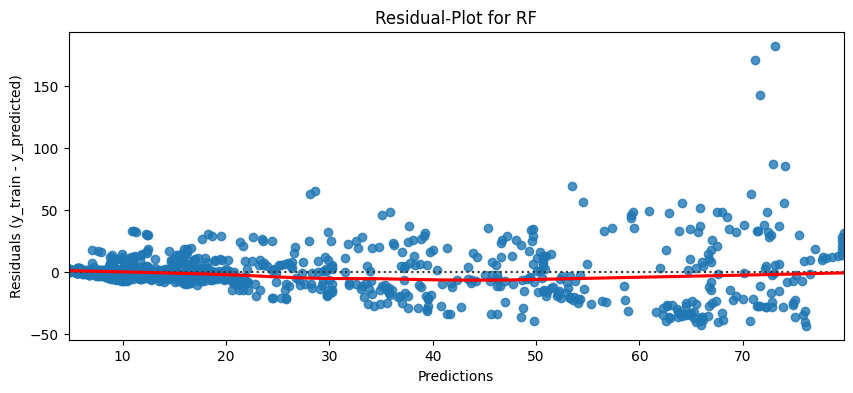

In [255]:
rf_y_predicts = cross_val_predict(best_rf_model, X_train, y_train, groups=group_train, cv=gk)
rf_residuals = y_train - rf_y_predicts

residual_plot(rf_y_predicts, rf_residuals, "RF")

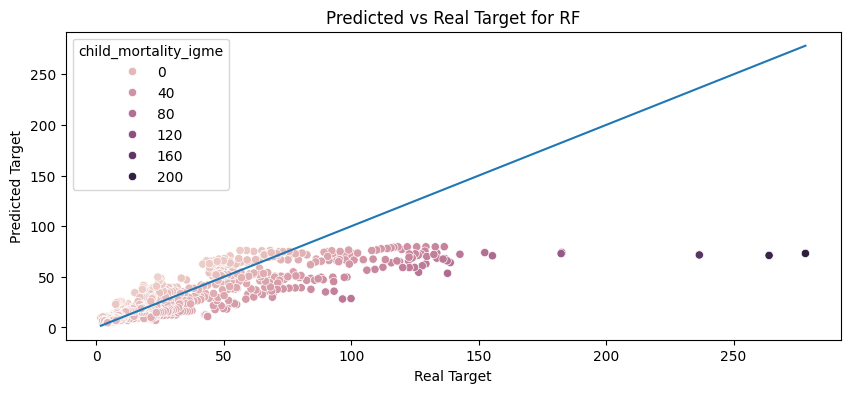

In [256]:
actual_vs_predicted(y_train, rf_y_predicts, rf_residuals, "RF")

In [257]:
rf_feature_pipeline = best_rf_model.regressor_
pre_pipeline = rf_feature_pipeline.named_steps['preprocess']
last_transformer = pre_pipeline.steps[-1][1]
feature_names_final = last_transformer.get_feature_names_out()
last_transformer
print("Die finalen Feature-Spalten, die dem RF-Modell übergeben wurden:")
print(feature_names_final)

Die finalen Feature-Spalten, die dem RF-Modell übergeben wurden:
['nurses_and_midwives_per_1000_people' 'physicians_per_1000_people'
 'prevalence_of_undernourishment' 'share_without_improved_water'
 'vaccination_coverage_who_unicef' 'years_of_schooling'
 'share_of_population_urban' 'healthcare_gdp_ratio'
 'world_regions_wb_East Asia and Pacific (WB)'
 'world_regions_wb_Europe and Central Asia (WB)'
 'world_regions_wb_Latin America and Caribbean (WB)'
 'world_regions_wb_Middle East, North Africa, Afghanistan and Pakistan (WB)'
 'world_regions_wb_North America (WB)' 'world_regions_wb_South Asia (WB)'
 'world_regions_wb_Sub-Saharan Africa (WB)'
 'world_income_group_High-income countries'
 'world_income_group_Low-income countries'
 'world_income_group_Lower-middle-income countries'
 'world_income_group_Upper-middle-income countries'
 'world_income_group_missing']


In [264]:
###Holdout Testset
#best_rf_model.fit(X_train, y_train)

holdout_test(best_rf_model, X_test)

----Holdout Testset: Final Metric Scores----
 MAE: 6.199147450027609, R2: 0.8202754817555943, RMSE: 9.58833434154355
[ 3.14110716  8.15637849 15.47827815 21.75716496]


### XGBoost

In [266]:
# -------------------------------------------------
# XGBOOST
#--------------------------------------------------
xgb_pipeline = Pipeline([
    ("preprocess", end_pipe),
    ("model", XGBRegressor(objective="reg:absoluteerror", n_jobs=-1, random_state=42))
])
#Target is rightskewed, logtransform y before training
xgb_pipeline_y_log = TransformedTargetRegressor(
    regressor=xgb_pipeline,
    func=np.log1p,
    inverse_func=np.expm1
)

xgb_param_grid = {
    "regressor__model__n_estimators": [200, 400],
    "regressor__model__learning_rate": [0.01, 0.1],
    "regressor__model__max_depth": [3, 5],
    "regressor__model__min_child_weight": [1, 5],
    "regressor__model__subsample": [0.8, 1.0],
    "regressor__model__reg_alpha": [0.01, 0.1]
}

xgb_search = GridSearchCV(xgb_pipeline_y_log, xgb_param_grid, cv=gk, scoring=metrics, refit="mae", n_jobs=-1, return_train_score=True)

xgb_search.fit(X_train, y_train, groups=group_train)

show_scores(xgb_search, "XGB")

best_xgb_model = xgb_search.best_estimator_
best_xgb_model


------XGB CV SCORES--------

R2:

Train Folds R2 Scores: [np.float64(0.89), np.float64(0.9), np.float64(0.89), np.float64(0.96), np.float64(0.91), np.float64(0.87), np.float64(0.88)]
            
Mean Train R2 Score: 0.9
            
Test Folds R2 Scores: [np.float64(0.58), np.float64(0.86), np.float64(0.82), np.float64(0.61), np.float64(0.64), np.float64(0.93), np.float64(0.85)]
            
Mean Test R2 Score (best_score_): 0.76)   
            
Std Test R2 Score: 0.13

MAE:

Train Folds MAE Scores: [np.float64(3.22), np.float64(3.26), np.float64(3.46), np.float64(2.73), np.float64(3.36), np.float64(3.75), np.float64(3.31)]
            
Mean Train MAE Score: 3.3
            
Test Folds MAE Scores: [np.float64(11.23), np.float64(6.41), np.float64(7.31), np.float64(13.94), np.float64(11.86), np.float64(6.44), np.float64(11.12)]
            
Mean Test MAE Score: 9.76
            
Std Test MAE Score: 2.78

RMSE:

Train Folds RMSE Scores: [np.float64(12.42), np.float64(11.33), np.float64

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocess',
                                                      Pipeline(steps=[('prep_nums',
                                                                       ColumnTransformer(remainder='passthrough',
                                                                                         transformers=[('log_nums',
                                                                                                        Pipeline(steps=[('knn_impute',
                                                                                                                         KNNImputer(weights='distance')),
                                                                                                                        ('log_transform',
                                                                                                                         FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                                             func=<uf...
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.01,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=3,
                                                                   max_leaves=None,
                                                                   min_child_weight=5,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   n_estimators=400,
                                                                   n_jobs=-1,
                                                                   num_parallel_tree=None,
                                                                   objective='reg:absoluteerror',
                                                                   predictor=None, ...))]))

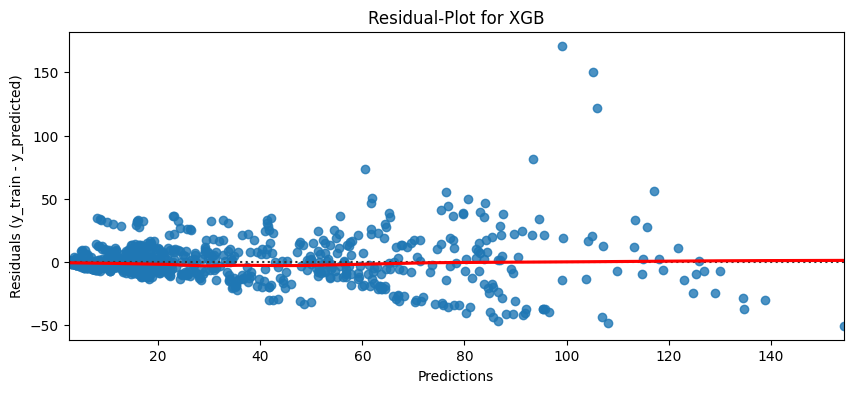

In [267]:
xgb_y_predicts = cross_val_predict(best_xgb_model, X_train, y_train, groups=group_train, cv=gk)
xgb_residuals = y_train - xgb_y_predicts

residual_plot(xgb_y_predicts, xgb_residuals, "XGB")

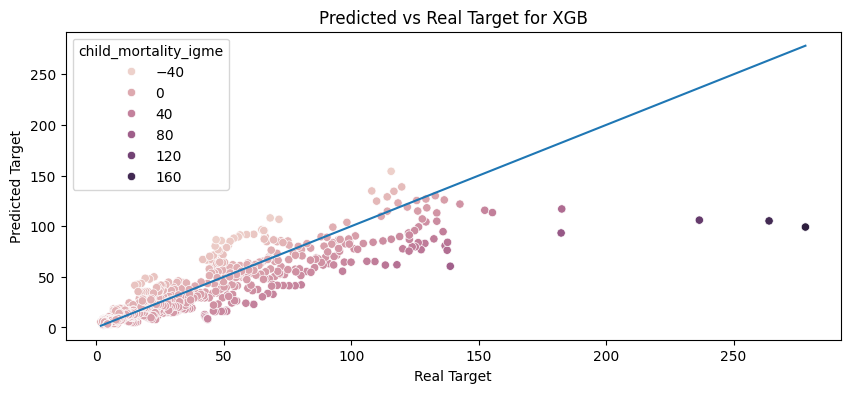

In [268]:
actual_vs_predicted(y_train, xgb_y_predicts, xgb_residuals, "XGB")

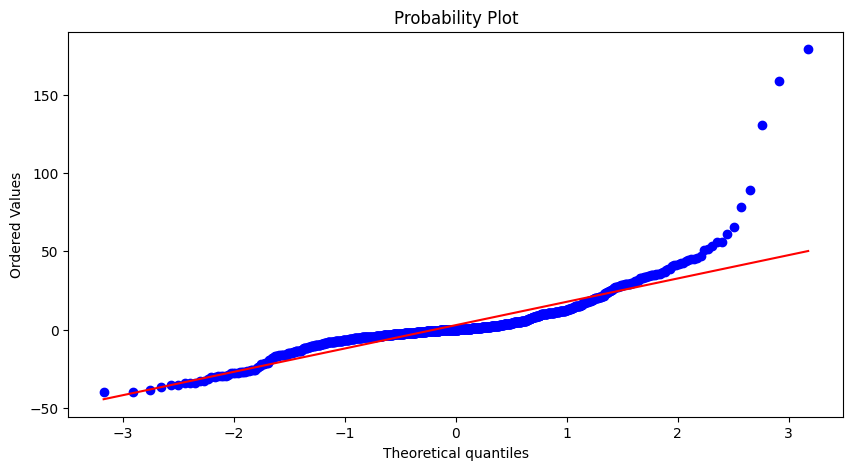

In [269]:
prob_plot(xgb_residuals)

#### Holdout Testset

In [270]:
#Holdout Testset
#best_xgb_model.fit(X_train, y_train)

holdout_test(best_xgb_model, X_test)

----Holdout Testset: Final Metric Scores----
 MAE: 5.929792100048372, R2: 0.828724773027901, RMSE: 9.360235619169181
[ 2.37361639  8.58206576 15.19244582 19.91416008]


### Extremes (Quantile)

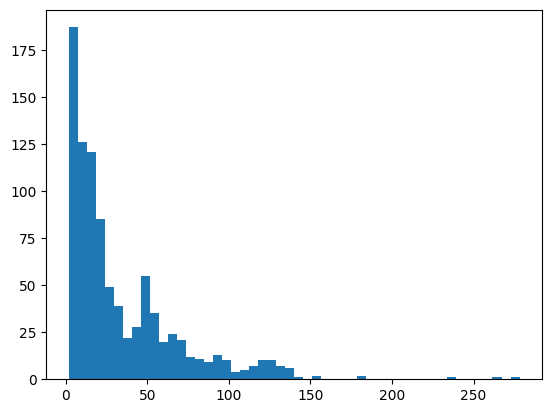

In [517]:
plt.hist(y_train, bins=50)
plt.show()

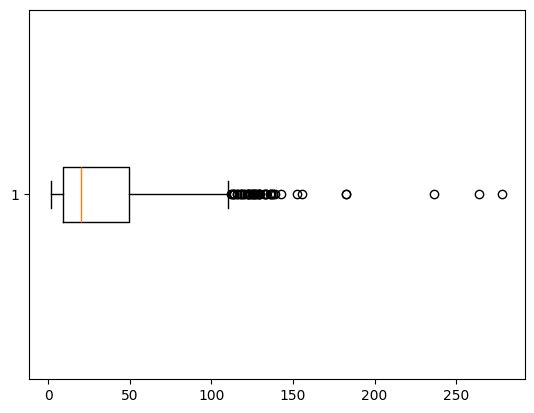

In [518]:
plt.boxplot(y_train, vert=False)
plt.show()

In [42]:
for q in [0.5, 0.70, 0.95]:
    print(f"{q*100:.0f}% Quant:", np.quantile(y_train, q))

qu = 0.95
threshold = np.quantile(y_train, qu)
n_extreme = (y_train > threshold).sum()
print("\nExtremes num:", n_extreme)

50% Quant: 20.0529625
70% Quant: 44.26989699999999
95% Quant: 113.22383799999992

Extremes num: 47


In [579]:
q50 = np.quantile(y_train, 0.5)
print("50%-Quantil (Median):", q50)

50%-Quantil (Median): 20.0529625


In [580]:
n_above_q50 = (y_train > q50).sum()
n_below_q50 = (y_train <= q50).sum()
print("Anzahl über q50:", n_above_q50)
print("Anzahl unter q50:", n_below_q50)

Anzahl über q50: 462
Anzahl unter q50: 462


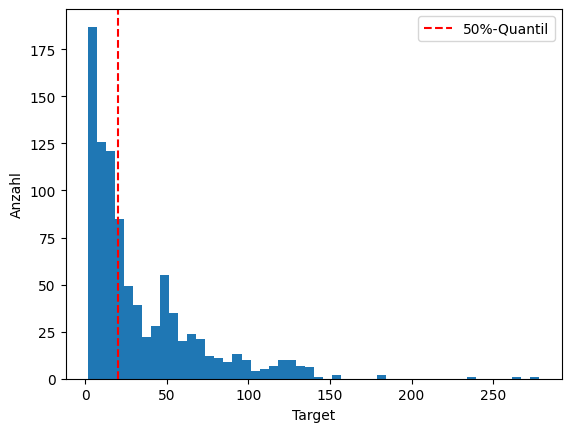

In [581]:
plt.hist(y_train, bins=50)
plt.axvline(q50, color='red', linestyle='--', label='50%-Quantil')
plt.xlabel("Target")
plt.ylabel("Anzahl")
plt.legend()
plt.show()

### Quantile Regression with GradientBoostingRegressor

In [13]:
# -------------------------------------------------
# GradientBoostingRegressor
#--------------------------------------------------
from sklearn.ensemble import GradientBoostingRegressor

def pinball_score(a):
    return make_scorer(
        mean_pinball_loss,
        alpha=a,
        greater_is_better=False
    )

gb_quantiles = [0.25, 0.5, 0.75]
gb_models = {}
gb_cv_results = {}


gb_param_grid = {
    "regressor__model__n_estimators": [200, 400],
    "regressor__model__max_depth": [2, 4],
    "regressor__model__learning_rate": [0.01, 0.05, 0.1]
}

for q in gb_quantiles:
    print(f"Train for {q}")
    
    gb_pipeline = Pipeline([
        ("preprocess", end_pipe),
        ("model", GradientBoostingRegressor(loss="quantile",alpha=q,random_state=99))
    ])

    gb_pipeline_y_log  = TransformedTargetRegressor(
        regressor=gb_pipeline,
        func=np.log1p,
        inverse_func=np.expm1
    )

    # fit trainset via GridSearchCV
    gb_grid = GridSearchCV(gb_pipeline_y_log, gb_param_grid, cv=gk, scoring=pinball_score(q), return_train_score=True, n_jobs=-1)
    gb_grid.fit(X_train, y_train, groups=group_train)

    gb_models[q] = gb_grid.best_estimator_
    #gb_models[q]
    print("Best params:", gb_grid.best_params_)
    #gb_results = pd.DataFrame(gb_grid.cv_results_)

Train for 0.25
Best params: {'regressor__model__learning_rate': 0.05, 'regressor__model__max_depth': 2, 'regressor__model__n_estimators': 400}
Train for 0.5
Best params: {'regressor__model__learning_rate': 0.05, 'regressor__model__max_depth': 4, 'regressor__model__n_estimators': 400}
Train for 0.75
Best params: {'regressor__model__learning_rate': 0.05, 'regressor__model__max_depth': 4, 'regressor__model__n_estimators': 400}


Coverage: 0.3225108225108225
Above diagonal: 0.6774891774891775
Below diagonal: 0.3225108225108225

Trainset: Quantile 0.25, Pinball Loss: 3.5860

mean=3.5860, std=0.9619
MAE: 11.1552, std=2.9312336779108588 R2: 0.6780, std=0.1141

Coverage: 0.5097402597402597
Above diagonal: 0.4902597402597403
Below diagonal: 0.5097402597402597

Trainset: Quantile 0.5, Pinball Loss: 5.1516

mean=5.1516, std=1.2364
MAE: 10.3032, std=2.47274636366388 R2: 0.7337, std=0.1198

Coverage: 0.6439393939393939
Above diagonal: 0.3560606060606061
Below diagonal: 0.6439393939393939

Trainset: Quantile 0.75, Pinball Loss: 4.9279

mean=4.9279, std=1.8070
MAE: 10.3277, std=3.0410480368392734 R2: 0.7632, std=0.1419



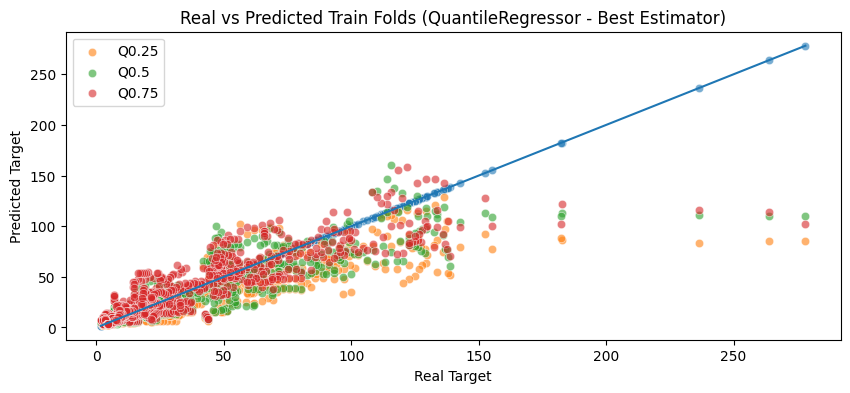

In [14]:
gb_y_pred_train = {}  
gb_residuals = {}
#Residuals & pinball mean losses
for q, model in gb_models.items():
    gb_y_pred_train[q] = cross_val_predict(model, X_train, y_train, groups=group_train, cv=gk)
    gb_residuals[q] = y_train - gb_y_pred_train[q]
    print("Coverage:", np.mean(y_train <= gb_y_pred_train[q]))
    print("Above diagonal:", np.mean(y_train > gb_y_pred_train[q]))
    print("Below diagonal:", np.mean(y_train < gb_y_pred_train[q]))

    loss = mean_pinball_loss(y_train, gb_y_pred_train[q], alpha=q)
    print(f"\nTrainset: Quantile {q}, Pinball Loss: {loss:.4f}\n")

    #pinball score + std
    gb_scorer = make_scorer(mean_pinball_loss, greater_is_better=False, alpha=q)
    gb_scores = cross_val_score(model, X_train, y_train, cv=gk, groups=group_train, scoring=gb_scorer)
    print(f"mean={-gb_scores.mean():.4f}, std={gb_scores.std():.4f}")
    #mae + r2 Zusatz
    gb_mae_scores = cross_val_score(model, X_train, y_train, cv=gk, groups=group_train, scoring="neg_mean_absolute_error")
    gb_r2_scores = cross_val_score(model, X_train, y_train, cv=gk, groups=group_train, scoring="r2")
    print(f"MAE: {-gb_mae_scores.mean():.4f}, std={gb_mae_scores.std()} R2: {gb_r2_scores.mean():.4f}, std={gb_r2_scores.std():.4f}\n")

#Real vs Predicted Scatterplots
plt.figure(figsize=(10,4))
sns.scatterplot(x=y_train, y=y_train, alpha=0.6)  
for q in gb_quantiles:
    sns.scatterplot(x=y_train, y=gb_y_pred_train[q], label=f'Q{q}', alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()])
plt.xlabel("Real Target")
plt.ylabel("Predicted Target")
plt.title("Real vs Predicted Train Folds (QuantileRegressor - Best Estimator)")
plt.legend()
plt.show()

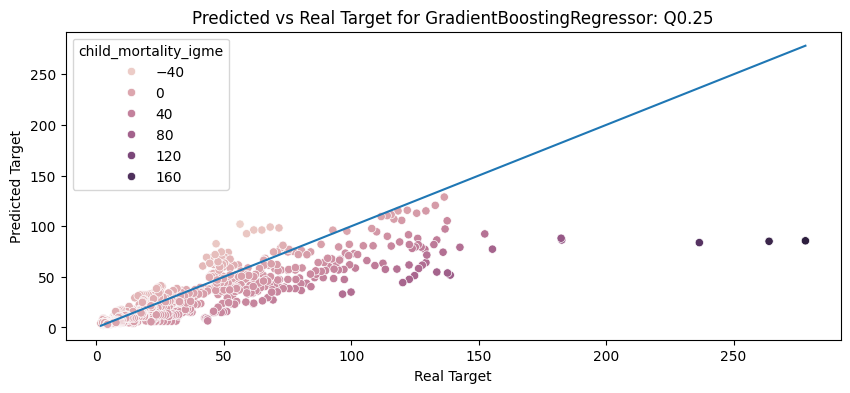

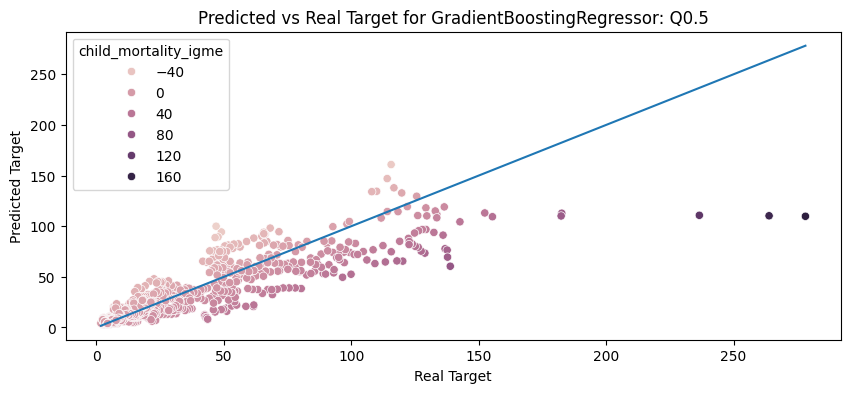

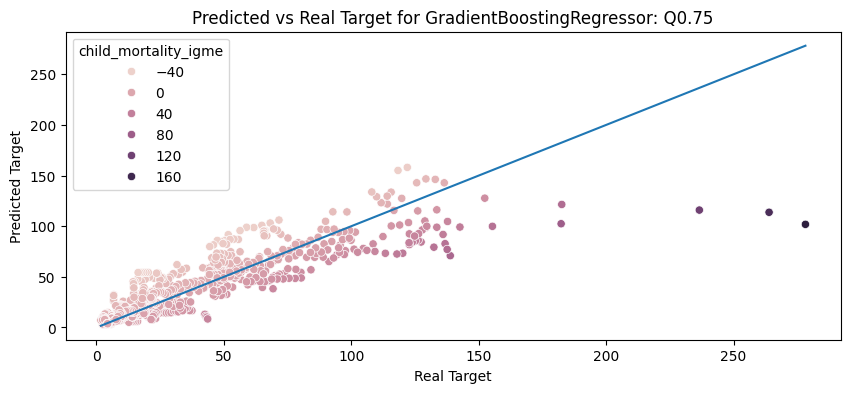

In [15]:
actual_vs_predicted(y_train, gb_y_pred_train[0.25], gb_residuals[0.25], f"GradientBoostingRegressor: Q{0.25}")
actual_vs_predicted(y_train, gb_y_pred_train[0.5], gb_residuals[0.5], f"GradientBoostingRegressor: Q{0.5}")
actual_vs_predicted(y_train, gb_y_pred_train[0.75], gb_residuals[0.75], f"GradientBoostingRegressor: Q{0.75}")

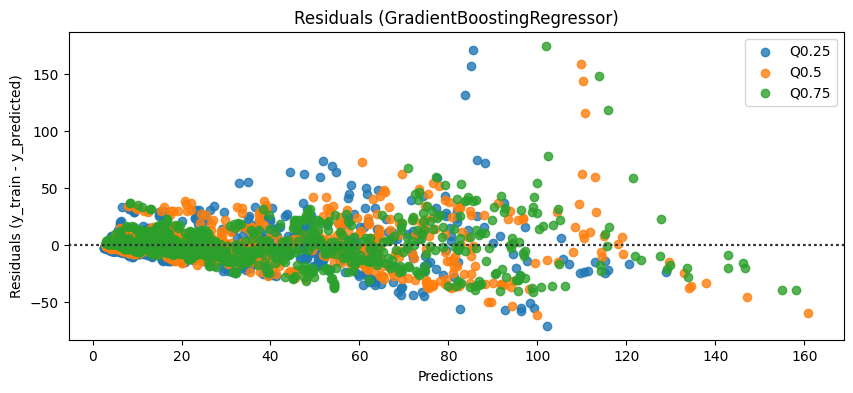

In [17]:
plt.figure(figsize=(10,4))
for q in gb_quantiles:
    #residual_plot(qr_y_pred_train[q], qr_residuals[q], f"Q{q}")
    sns.residplot(x=gb_y_pred_train[q], y=gb_residuals[q], label=f'Q{q}')
plt.title(f"Residuals (GradientBoostingRegressor)")
plt.xlabel("Predictions")
plt.ylabel("Residuals (y_train - y_predicted)")
plt.legend()
plt.show()

#### Holdout Test

In [20]:
gb_y_pred_test = {}
gb_test_residuals = {}
for q, model in gb_models.items():
    #model.fit(X_train, y_train)
    #holdout_test(model, X_test)
    gb_y_pred_test[q] = model.predict(X_test)

    gb_test_residuals[q] = y_test - gb_y_pred_test[q]
    print("Coverage:", np.mean(y_test <= gb_y_pred_test[q]))
    print("Above:", np.mean(y_test > gb_y_pred_test[q]))
    print("Below:", np.mean(y_test < gb_y_pred_test[q]))

    loss = mean_pinball_loss(y_test, gb_y_pred_test[q], alpha=q)
    print(f"\nQuantile {q}, Pinball Loss: {loss:.4f}\n")

#mae_025 = mean_absolute_error(y_test, qr_y_pred_test[0.25])
mae_05 = mean_absolute_error(y_test, gb_y_pred_test[0.5])
#mae_075 = mean_absolute_error(y_test, qr_y_pred_test[0.75])
print(f"\nQ0.5 MAE: {mae_05}")

Coverage: 0.41025641025641024
Above: 0.5897435897435898
Below: 0.41025641025641024

Quantile 0.25, Pinball Loss: 2.3120

Coverage: 0.5512820512820513
Above: 0.44871794871794873
Below: 0.5512820512820513

Quantile 0.5, Pinball Loss: 2.8198

Coverage: 0.6581196581196581
Above: 0.3418803418803419
Below: 0.6581196581196581

Quantile 0.75, Pinball Loss: 2.2009


Q0.5 MAE: 5.639548864777012


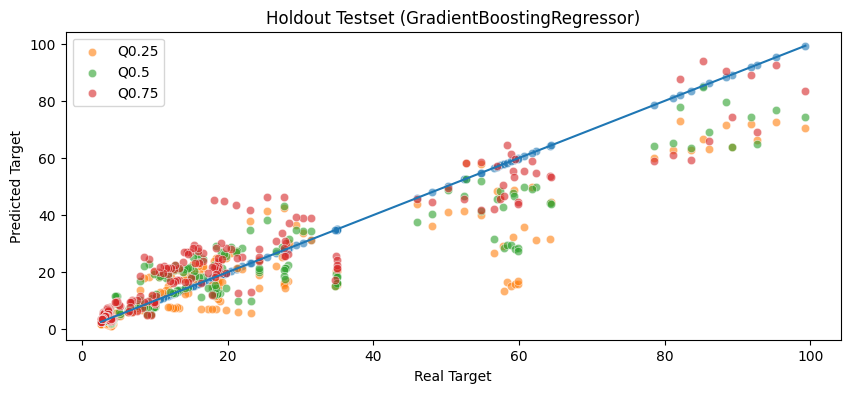

In [21]:
plt.figure(figsize=(10,4))
sns.scatterplot(x=y_test, y=y_test, alpha=0.6)  
for q in gb_quantiles:
    sns.scatterplot(x=y_test, y=gb_y_pred_test[q], label=f'Q{q}', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.xlabel("Real Target")
plt.ylabel("Predicted Target")
plt.title("Holdout Testset (GradientBoostingRegressor)")
plt.legend()
plt.show()

### Quantile Regression with QuantileRegressor

In [22]:
# -------------------------------------------------
# QuantileRegressor
#--------------------------------------------------
#https://xgboosting.com/xgboost-prediction-interval-using-quantile-regression/
from sklearn.linear_model import QuantileRegressor
from joblib import dump, load

qr_quantiles = [0.25, 0.5, 0.75]
qr_models = {}
cv_results = {}

def pinball_scoring(a):
    return make_scorer(
        mean_pinball_loss,
        alpha=a,
        greater_is_better=False
    )

qr_param_grid = {
    "regressor__model__alpha": [0.01, 0.05, 0.1, 0.5, 1]
}

for q in qr_quantiles:
    print(f"Train for {q}")
    
    qr_pipeline = Pipeline([
        ("preprocess", end_pipe),
        ("model", QuantileRegressor(quantile=q))
    ])

    qr_pipeline_y_log = TransformedTargetRegressor(
        regressor=qr_pipeline,
        func=np.log1p,
        inverse_func=np.expm1
    )

    # fit trainset via GridSearchCV
    qr_grid = GridSearchCV(qr_pipeline_y_log, qr_param_grid, cv=gk, scoring=pinball_scoring(q), return_train_score=True, n_jobs=-1)
    qr_grid.fit(X_train, y_train, groups=group_train)

    qr_models[q] = qr_grid.best_estimator_
    print("Best params:", qr_grid.best_params_)
#qr_grid.best_estimator_
    #gb_results = pd.DataFrame(gb_grid.cv_results_)
    #print(gb_results[["params", "mean_test_score", "rank_test_score"]])

Train for 0.25
Best params: {'regressor__model__alpha': 0.01}
Train for 0.5
Best params: {'regressor__model__alpha': 0.01}
Train for 0.75
Best params: {'regressor__model__alpha': 0.01}


#### Train Folds Performance per Q

Coverage: 0.2803030303030303
Above: 0.7196969696969697
Below: 0.2803030303030303

Folds CV: Quantile 0.25, Folds Mean Pinball Loss: 3.5232
mean=3.5232, std=0.7319
MAE: 11.7962, std=2.605306801622872 R2: 0.6323, std=0.1259

Coverage: 0.5021645021645021
Above: 0.49783549783549785
Below: 0.5021645021645021

Folds CV: Quantile 0.5, Folds Mean Pinball Loss: 5.2857
mean=5.2857, std=1.5085
MAE: 10.5714, std=3.016996152248251 R2: 0.7384, std=0.1349

Coverage: 0.7261904761904762
Above: 0.27380952380952384
Below: 0.7261904761904762

Folds CV: Quantile 0.75, Folds Mean Pinball Loss: 4.7827
mean=4.7827, std=1.6644
MAE: 12.2928, std=3.960475731329899 R2: 0.6786, std=0.1555



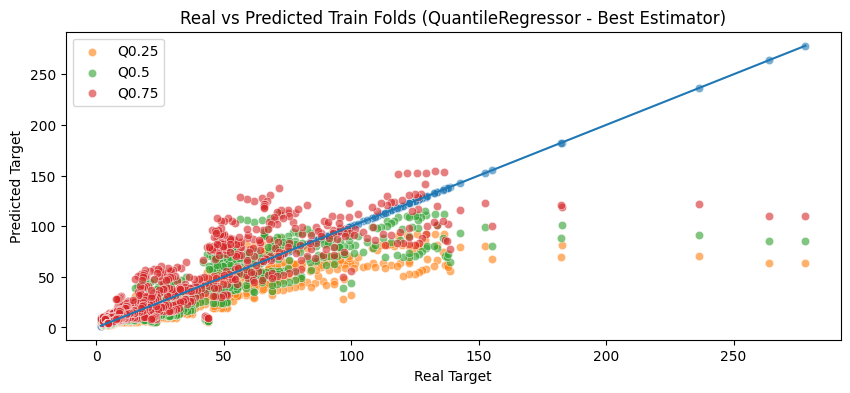

In [23]:
#qr_y_training_pred= {}

qr_y_pred_train = {}  
qr_residuals = {}
#Residuals & pinball mean losses
for q, model in qr_models.items():
    qr_y_pred_train[q] = cross_val_predict(model, X_train, y_train, groups=group_train, cv=gk)
    qr_residuals[q] = y_train - qr_y_pred_train[q]
    print("Coverage:", np.mean(y_train <= qr_y_pred_train[q]))
    print("Above:", np.mean(y_train > qr_y_pred_train[q]))
    print("Below:", np.mean(y_train < qr_y_pred_train[q]))

    loss = mean_pinball_loss(y_train, qr_y_pred_train[q], alpha=q)
    print(f"\nFolds CV: Quantile {q}, Folds Mean Pinball Loss: {loss:.4f}")

    #pinball score + std
    qr_scorer = make_scorer(mean_pinball_loss, greater_is_better=False, alpha=q)
    qr_scores = cross_val_score(model, X_train, y_train, cv=gk, groups=group_train, scoring=qr_scorer)
    print(f"mean={-qr_scores.mean():.4f}, std={qr_scores.std():.4f}")
    #mae + r2 Zusatz
    qr_mae_scores = cross_val_score(model, X_train, y_train, cv=gk, groups=group_train, scoring="neg_mean_absolute_error")
    qr_r2_scores = cross_val_score(model, X_train, y_train, cv=gk, groups=group_train, scoring="r2")
    print(f"MAE: {-qr_mae_scores.mean():.4f}, std={qr_mae_scores.std()} R2: {qr_r2_scores.mean():.4f}, std={qr_r2_scores.std():.4f}\n")
    #print("Fold MAE Scores": qr_mae_scores)

#Real vs Predicted Scatterplots
plt.figure(figsize=(10,4))
sns.scatterplot(x=y_train, y=y_train, alpha=0.6)  
for q in qr_quantiles:
    sns.scatterplot(x=y_train, y=qr_y_pred_train[q], label=f'Q{q}', alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()])
plt.xlabel("Real Target")
plt.ylabel("Predicted Target")
plt.title("Real vs Predicted Train Folds (QuantileRegressor - Best Estimator)")
plt.legend()
plt.show()

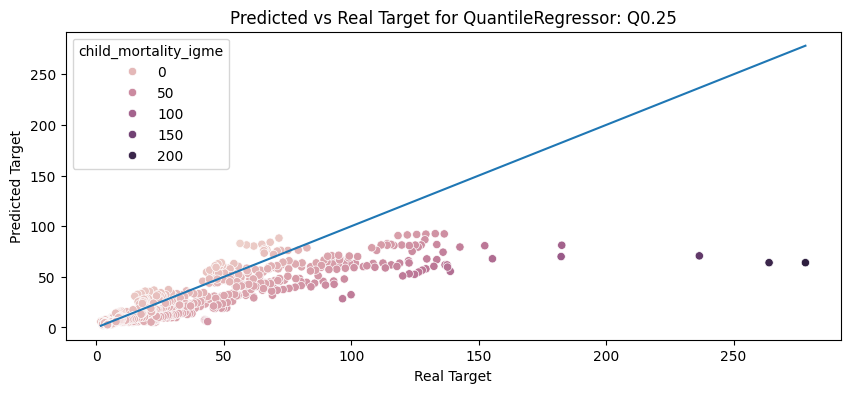

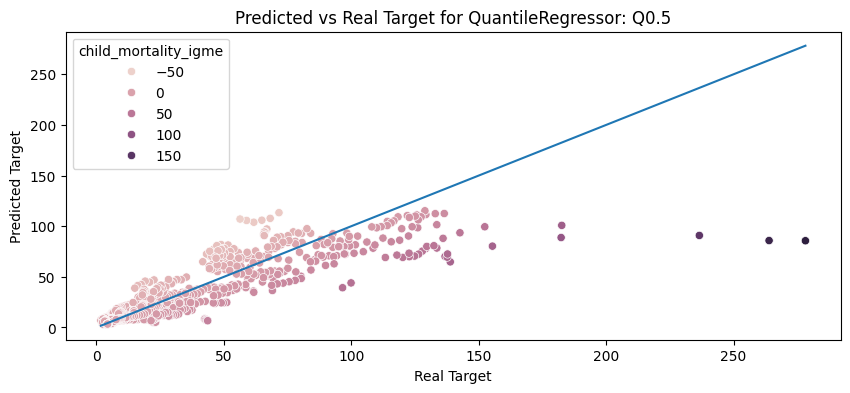

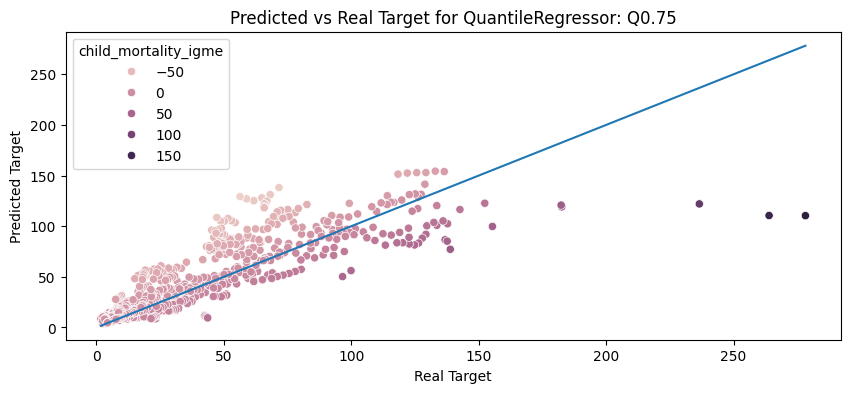

In [15]:
actual_vs_predicted(y_train, qr_y_pred_train[0.25], qr_residuals[0.25], f"QuantileRegressor: Q{0.25}")
actual_vs_predicted(y_train, qr_y_pred_train[0.5], qr_residuals[0.5], f"QuantileRegressor: Q{0.5}")
actual_vs_predicted(y_train, qr_y_pred_train[0.75], qr_residuals[0.75], f"QuantileRegressor: Q{0.75}")

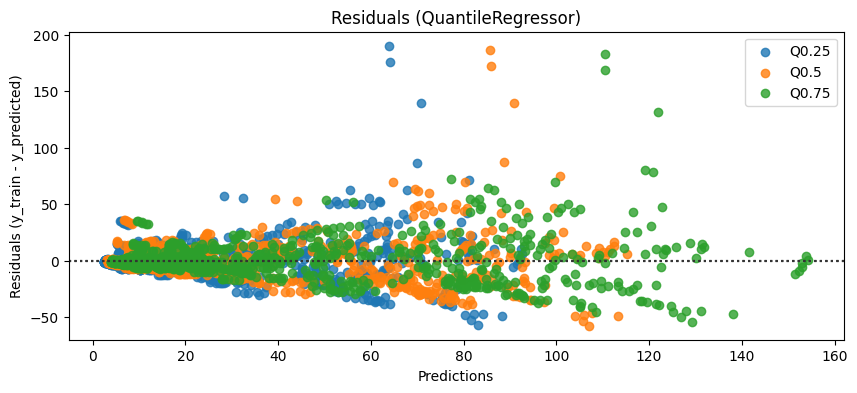

In [16]:
plt.figure(figsize=(10,4))
for q in qr_quantiles:
    #residual_plot(qr_y_pred_train[q], qr_residuals[q], f"Q{q}")
    sns.residplot(x=qr_y_pred_train[q], y=qr_residuals[q], label=f'Q{q}')
plt.title(f"Residuals (QuantileRegressor)")
plt.xlabel("Predictions")
plt.ylabel("Residuals (y_train - y_predicted)")
plt.legend()
plt.show()

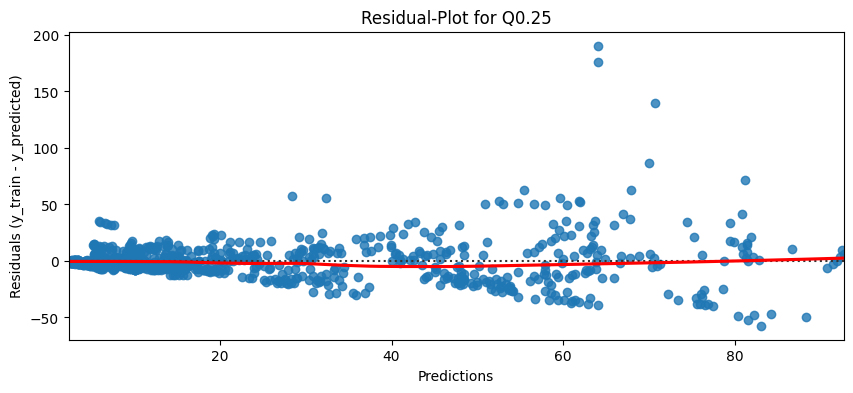

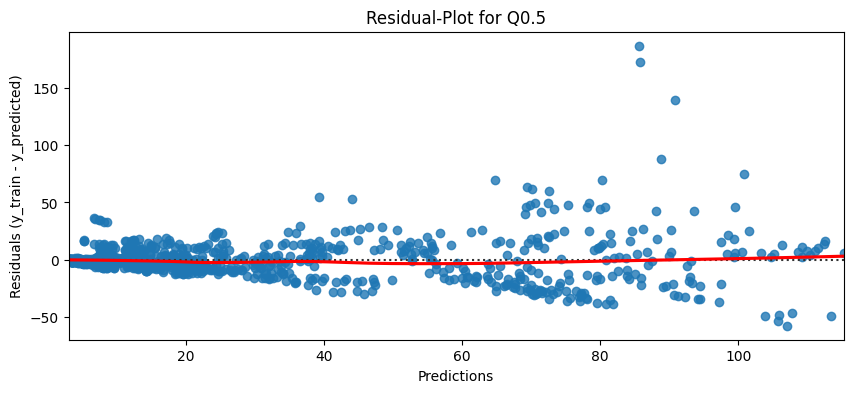

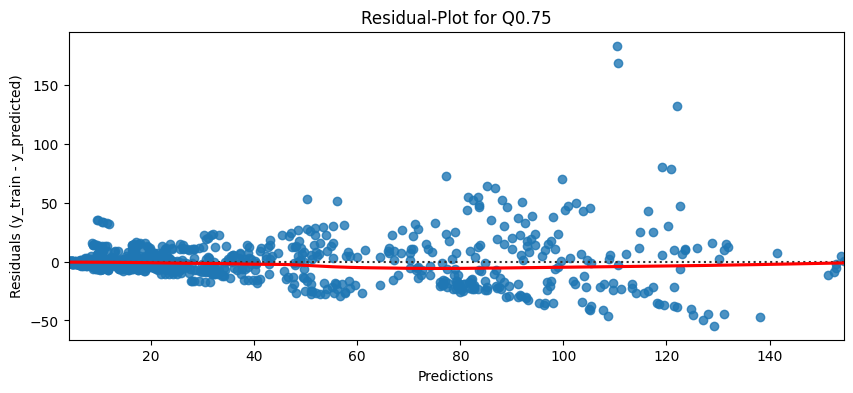

In [17]:
residual_plot(qr_y_pred_train[0.25], qr_residuals[0.25], f"Q{0.25}")
residual_plot(qr_y_pred_train[0.5], qr_residuals[0.5], f"Q{0.5}")
residual_plot(qr_y_pred_train[0.75], qr_residuals[0.75], f"Q{0.75}")

In [283]:
qr_results = pd.DataFrame(qr_grid.cv_results_)
qr_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.294021      0.008614         0.060845        0.006639   
1       0.284087      0.012768         0.061436        0.006106   
2       0.263747      0.008768         0.063282        0.005222   
3       0.242255      0.006981         0.061199        0.003828   
4       0.226900      0.020471         0.056089        0.007282   

   param_regressor__model__alpha                             params  \
0                           0.01  {'regressor__model__alpha': 0.01}   
1                           0.05  {'regressor__model__alpha': 0.05}   
2                           0.10   {'regressor__model__alpha': 0.1}   
3                           0.50   {'regressor__model__alpha': 0.5}   
4                           1.00     {'regressor__model__alpha': 1}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0          -4.578884          -2.846586          -3.520599          -8.164748   
1          -4.805553          -3.307363          -3.314992          -7.902374   
2          -5.289061          -4.817132          -3.754828          -9.119570   
3          -9.298203         -10.369287          -9.883739         -15.027138   
4          -9.298203         -10.369287          -9.883739         -15.027138   

   split4_test_score  split5_test_score  split6_test_score  mean_test_score  \
0          -5.813366          -3.571553          -4.983115        -4.782693   
1          -6.448194          -3.808652          -6.048473        -5.090800   
2          -7.791208          -7.637478          -8.803834        -6.744730   
3         -11.154322         -14.913829         -17.536202       -12.597531   
4         -11.154322         -14.913829         -17.536202       -12.597531   

   std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0        1.664355                1           -4.254579           -4.358130   
1        1.635500                2           -4.589474           -4.876712   
2        1.947380                3           -5.903128           -6.554077   
3        2.950953                4          -13.112660          -12.937227   
4        2.950953                4          -13.112660          -12.937227   

   split2_train_score  split3_train_score  split4_train_score  \
0           -4.424924           -3.641106           -3.981096   
1           -4.868070           -4.091925           -4.537429   
2           -5.975438           -5.647340           -5.837823   
3          -13.019619          -12.159697          -12.803253   
4          -13.019619          -12.159697          -12.803253   

   split5_train_score  split6_train_score  mean_train_score  std_train_score  
0           -4.404060           -4.224639         -4.184076         0.261678  
1           -4.913815           -4.506608         -4.626290         0.270703  
2           -6.621876           -6.216714         -6.108056         0.342182  
3          -12.176122          -11.743616        -12.564599         0.491658  
4          -12.176122          -11.743616        -12.564599         0.491658

#### SHAP Explanations

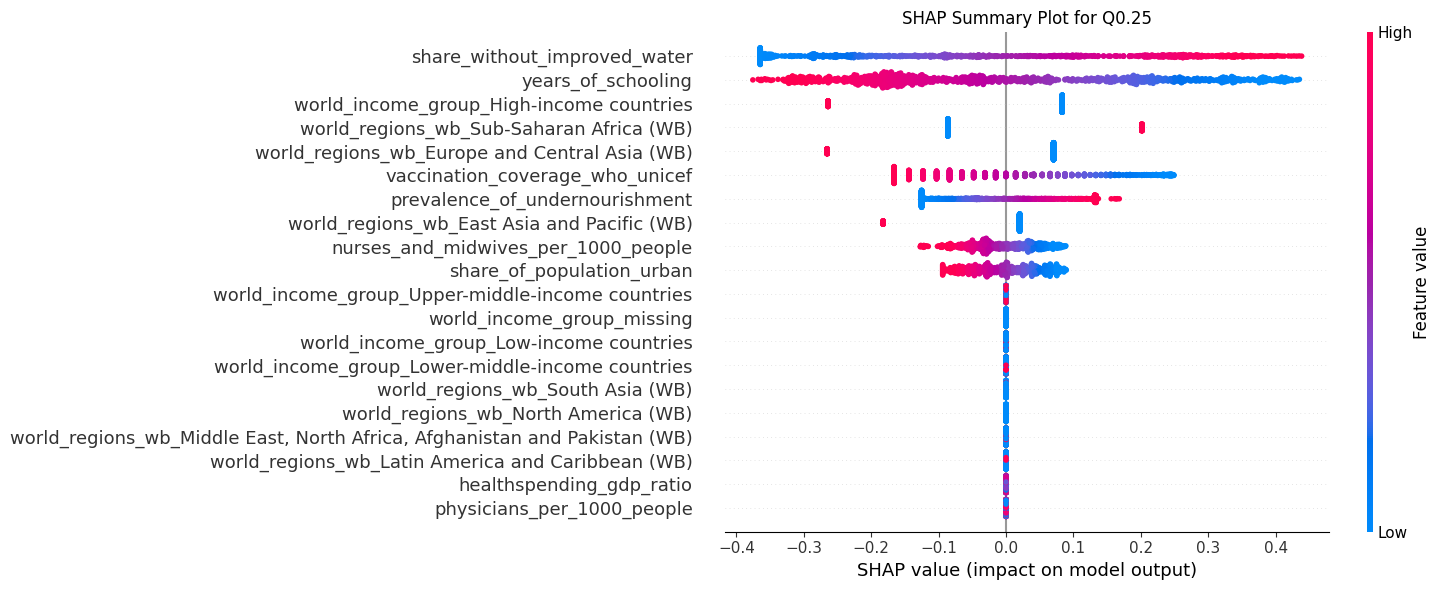

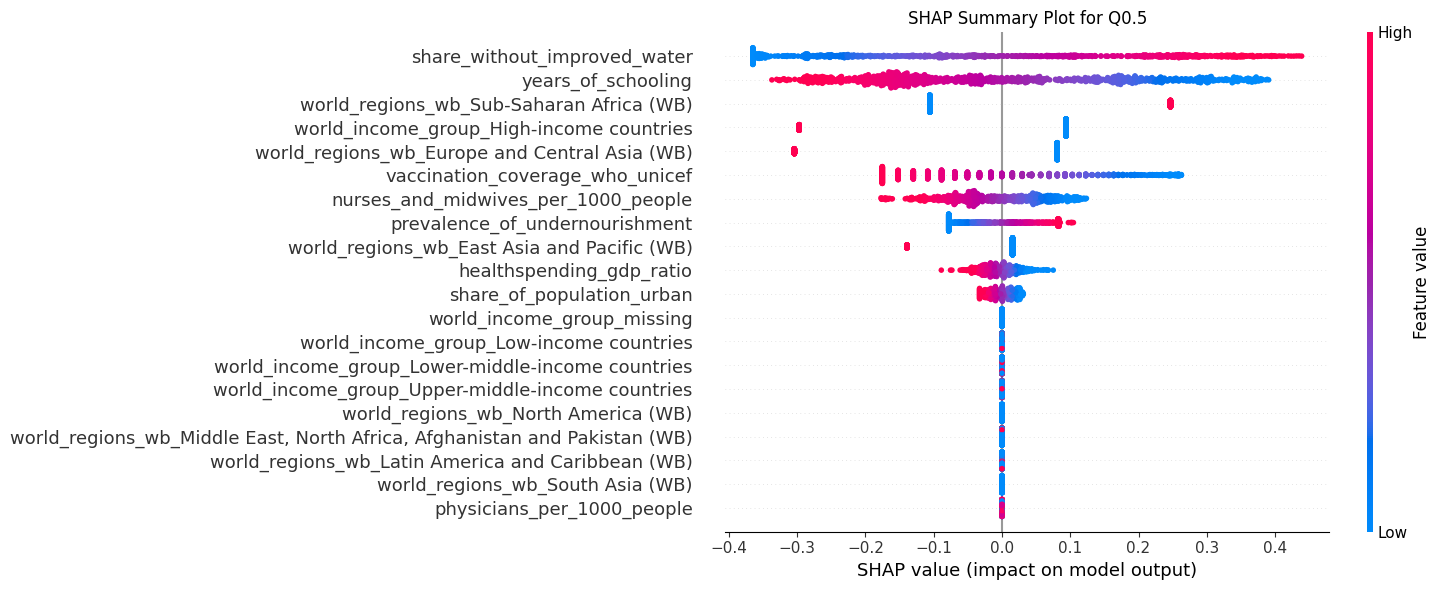

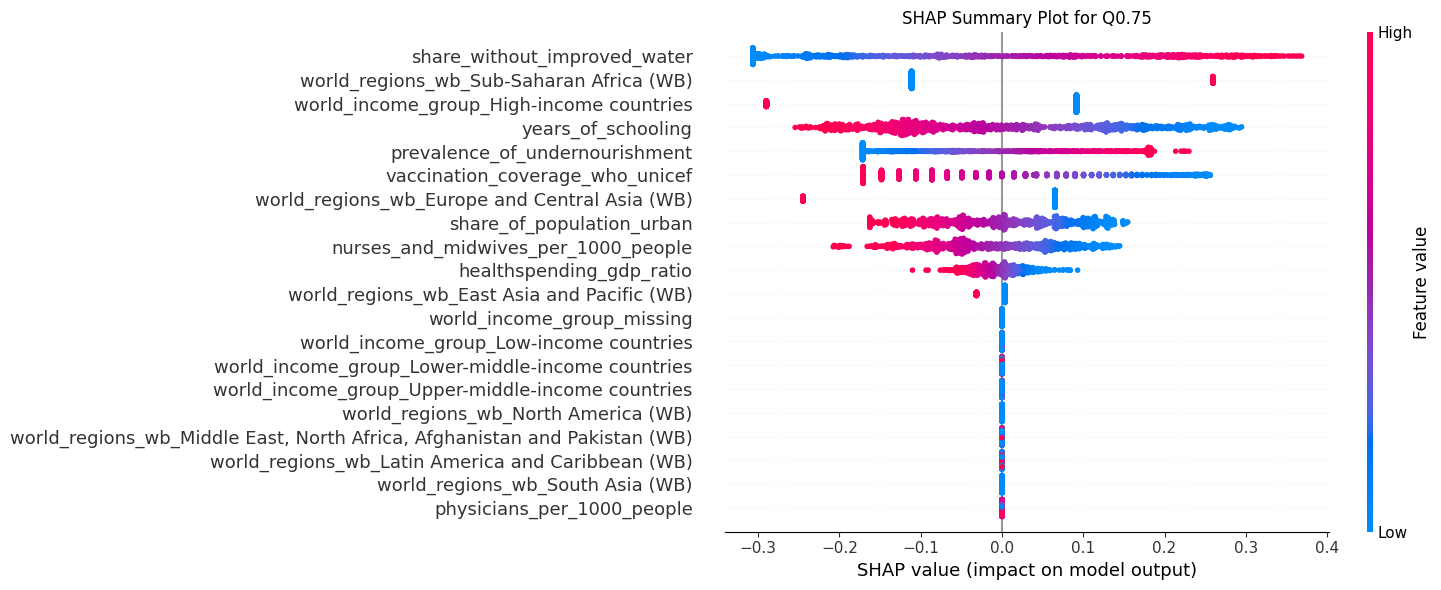

In [80]:
import shap
rng = np.random.default_rng(seed=42)

for q, model in qr_models.items():
    qr_pipeline = model.regressor_
    qr_pre = qr_pipeline.named_steps["preprocess"]
    qr_model = qr_pipeline.named_steps["model"]

    X_qr_transf = qr_pre.transform(X_train)
    X_qr_features = qr_pre.get_feature_names_out()

    expl = shap.Explainer(qr_model, X_qr_transf)
    shapvals = expl(X_qr_transf)
    shapvals.feature_names = list(X_qr_features)
    
    plt.title(f"SHAP Summary Plot for Q{q}")
    shap.summary_plot(shapvals, X_qr_transf, feature_names=X_qr_features, rng=rng, plot_size=[15,6],  max_display=25)
    #shap.plots.waterfall(shapvals[0]) #first sample observation

    #shap.plots.waterfall(shap_vals[0])
    #shap.dependence_plot("share_without_improved_water", shapvals, X_qr_transf)
    plt.show()

#### Holdout Testset

In [27]:
qr_y_pred_test = {}
qr_test_residuals = {}
for q, model in qr_models.items():
    #model.fit(X_train, y_train)
    #holdout_test(model, X_test)
    qr_y_pred_test[q] = model.predict(X_test)

    qr_test_residuals[q] = y_test - qr_y_pred_test[q]
    print("Coverage:", np.mean(y_test <= qr_y_pred_test[q]))
    print("Above:", np.mean(y_test > qr_y_pred_test[q]))
    print("Below:", np.mean(y_test < qr_y_pred_test[q]))

    loss = mean_pinball_loss(y_test, qr_y_pred_test[q], alpha=q)
    print(f"\nQuantile {q}, Pinball Loss: {loss:.4f}\n")

#mae_025 = mean_absolute_error(y_test, qr_y_pred_test[0.25])
mae_05 = mean_absolute_error(y_test, qr_y_pred_test[0.5])
#mae_075 = mean_absolute_error(y_test, qr_y_pred_test[0.75])
print(f"\nQ0.5 MAE: {mae_05}")

Coverage: 0.3247863247863248
Above: 0.6752136752136753
Below: 0.3247863247863248

Quantile 0.25, Pinball Loss: 2.1526

Coverage: 0.5555555555555556
Above: 0.4444444444444444
Below: 0.5555555555555556

Quantile 0.5, Pinball Loss: 2.7216

Coverage: 0.7948717948717948
Above: 0.20512820512820512
Below: 0.7948717948717948

Quantile 0.75, Pinball Loss: 2.2006


Q0.5 MAE: 5.443100859205762


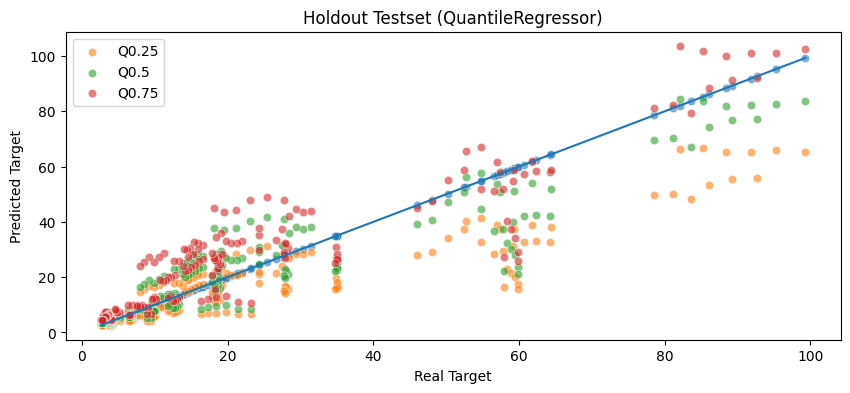

In [28]:
plt.figure(figsize=(10,4))
sns.scatterplot(x=y_test, y=y_test, alpha=0.6)  
for q in qr_quantiles:
    sns.scatterplot(x=y_test, y=qr_y_pred_test[q], label=f'Q{q}', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.xlabel("Real Target")
plt.ylabel("Predicted Target")
plt.title("Holdout Testset (QuantileRegressor)")
plt.legend()
plt.show()

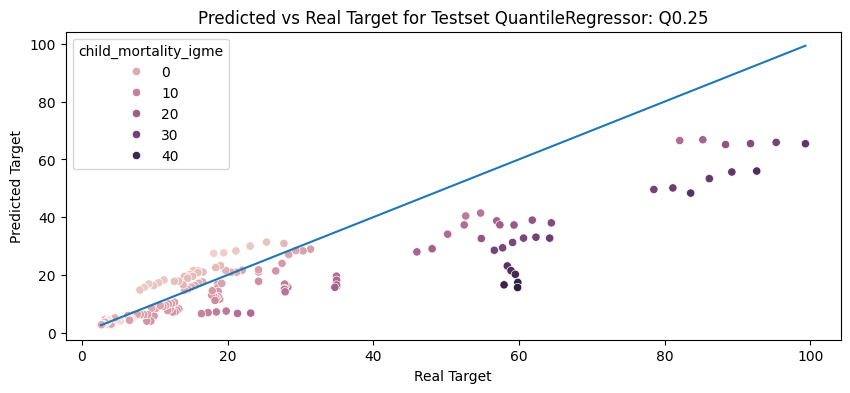

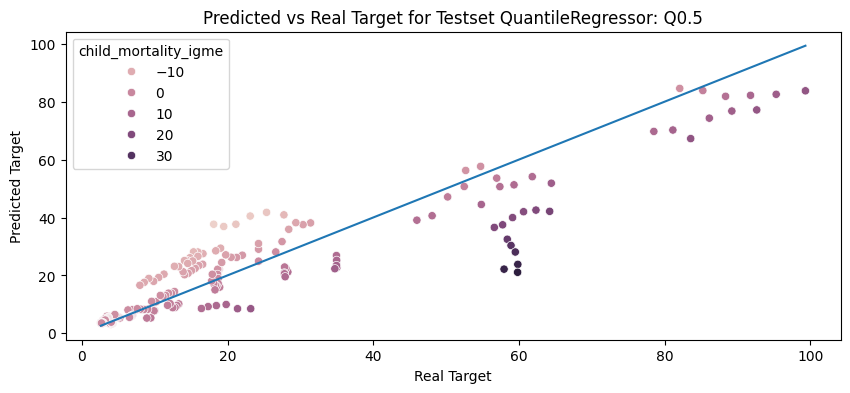

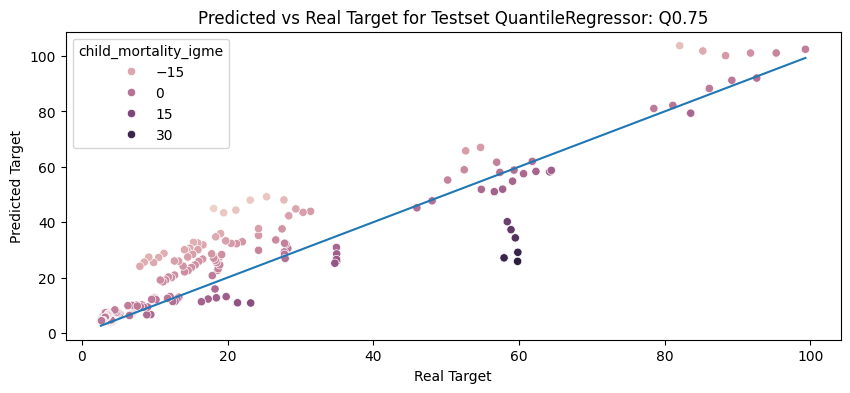

In [29]:
actual_vs_predicted(y_test, qr_y_pred_test[0.25], qr_test_residuals[0.25], f"Testset QuantileRegressor: Q{0.25}")
actual_vs_predicted(y_test, qr_y_pred_test[0.5], qr_test_residuals[0.5], f"Testset QuantileRegressor: Q{0.5}")
actual_vs_predicted(y_test, qr_y_pred_test[0.75], qr_test_residuals[0.75], f"Testset QuantileRegressor: Q{0.75}")

In [134]:
#Test new data sample 
bangladesh_new = [{'Entity': 'Bangladesh', 'annual_healthcare_expenditure_per_capita': 120, 'gdp_per_capita_worldbank': 3000, 'nurses_and_midwives_per_1000_people': 10.5, 'physicians_per_1000_people': 0.5, 'prevalence_of_undernourishment': 20.8, 'share_of_population_urban': 16, 'share_without_improved_water': 80.2, 'vaccination_coverage_who_unicef': 98, 'years_of_schooling': 2, 'world_regions_wb': 'South Asia (WB)', 'world_income_group': 'Lower-middle-income countries'}]
bangladesh_df = pd.DataFrame(bangladesh_new)

In [135]:
qr_y_pred_test_bang = {}
qr_test_residuals_bang = {}
for q, model in qr_models.items():

    qr_y_pred_test_bang[q] = model.predict(bangladesh_df)
print(qr_y_pred_test_bang)


{0.25: array([43.52937209]), 0.5: array([47.7911293]), 0.75: array([57.08634841])}


In [136]:
qr_y_pred_test_bang[0.25]

array([43.52937209])

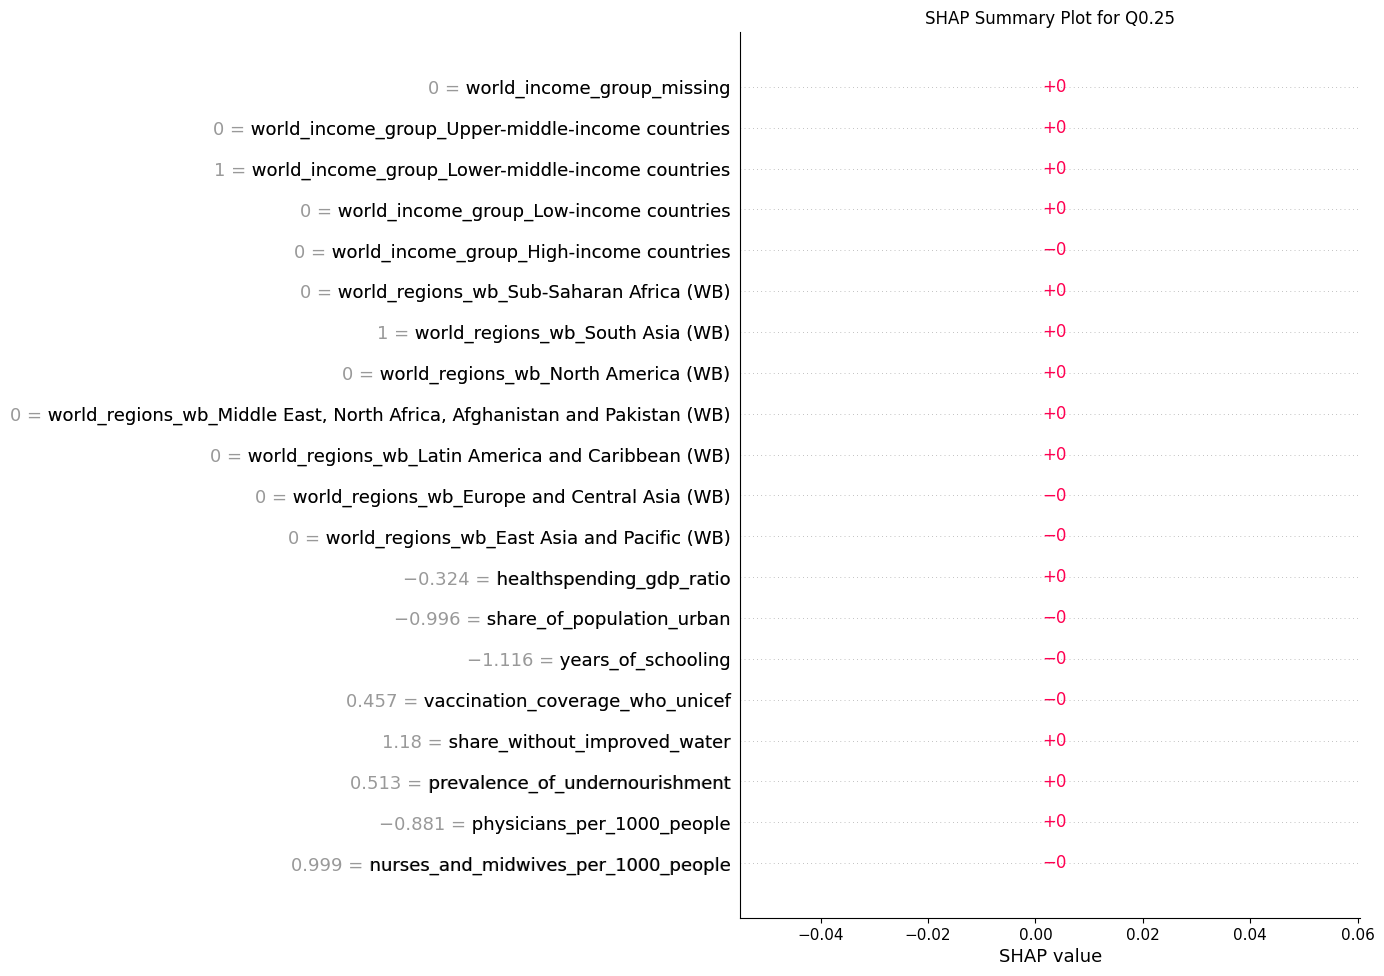

In [ ]:
for q, model in qr_models.items():
    qr_pipeline = model.regressor_
    qr_pre = qr_pipeline.named_steps["preprocess"]
    qr_model = qr_pipeline.named_steps["model"]

    X_qr_transf = qr_pre.transform(bangladesh_df)
    X_qr_features = qr_pre.get_feature_names_out()

    expl = shap.Explainer(qr_model, X_qr_transf)
    shapvals = expl(X_qr_transf)
    shapvals.feature_names = list(X_qr_features)
    
    plt.title(f"SHAP Summary Plot for Q{q}")
    #shap.summary_plot(shapvals, X_qr_transf, feature_names=X_qr_features, rng=rng, plot_size=[15,6],  max_display=25)
    shap.plots.bar(shapvals[0], max_display=20) #first sample observation

    #shap.plots.waterfall(shap_vals[0])
    #shap.dependence_plot("share_without_improved_water", shapvals, X_qr_transf)
    plt.show()

#### Permutation Importance

In [288]:
pi_result_qr = permutation_importance(qr_models[0.75], X_test, y_test, n_repeats=40, random_state=42)
importance_df_qr = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': np.round(pi_result_qr.importances_mean, 4),
    'importance_std': np.round(pi_result_qr.importances_std, 4)
}).sort_values(by='importance_mean', ascending=False)

importance_df_qr

feature  importance_mean  importance_std
10                          world_regions_wb           0.1478          0.0250
7               share_without_improved_water           0.1238          0.0210
2                   gdp_per_capita_worldbank           0.0659          0.0102
8            vaccination_coverage_who_unicef           0.0433          0.0112
11                        world_income_group           0.0422          0.0148
9                         years_of_schooling           0.0296          0.0110
1   annual_healthcare_expenditure_per_capita           0.0200          0.0089
6                  share_of_population_urban           0.0117          0.0067
0                                     Entity           0.0000          0.0000
4                 physicians_per_1000_people          -0.0001          0.0004
3        nurses_and_midwives_per_1000_people          -0.0007          0.0067
5             prevalence_of_undernourishment          -0.0150          0.0084

In [289]:
pi_result_qr5 = permutation_importance(qr_models[0.5], X_test, y_test, n_repeats=40, random_state=42)
importance_df_qr5 = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': np.round(pi_result_qr5.importances_mean, 4),
    'importance_std': np.round(pi_result_qr5.importances_std, 4)
}).sort_values(by='importance_mean', ascending=False)

importance_df_qr5

feature  importance_mean  importance_std
7               share_without_improved_water           0.2357          0.0281
10                          world_regions_wb           0.2327          0.0286
9                         years_of_schooling           0.1469          0.0191
11                        world_income_group           0.1081          0.0194
8            vaccination_coverage_who_unicef           0.0771          0.0116
1   annual_healthcare_expenditure_per_capita           0.0564          0.0079
3        nurses_and_midwives_per_1000_people           0.0360          0.0067
5             prevalence_of_undernourishment           0.0087          0.0042
6                  share_of_population_urban           0.0063          0.0012
4                 physicians_per_1000_people           0.0002          0.0002
0                                     Entity           0.0000          0.0000
2                   gdp_per_capita_worldbank          -0.0101          0.0039

In [290]:
pi_result_qr25 = permutation_importance(qr_models[0.25], X_test, y_test, n_repeats=40, random_state=42)
importance_df_qr25 = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': np.round(pi_result_qr25.importances_mean, 4),
    'importance_std': np.round(pi_result_qr25.importances_std, 4)
}).sort_values(by='importance_mean', ascending=False)

importance_df_qr25

feature  importance_mean  importance_std
7               share_without_improved_water           0.2690          0.0295
10                          world_regions_wb           0.2254          0.0256
9                         years_of_schooling           0.2176          0.0238
11                        world_income_group           0.1281          0.0202
8            vaccination_coverage_who_unicef           0.0864          0.0134
5             prevalence_of_undernourishment           0.0461          0.0089
3        nurses_and_midwives_per_1000_people           0.0451          0.0063
6                  share_of_population_urban           0.0276          0.0048
1   annual_healthcare_expenditure_per_capita           0.0067          0.0013
2                   gdp_per_capita_worldbank           0.0003          0.0003
4                 physicians_per_1000_people           0.0003          0.0001
0                                     Entity           0.0000          0.0000

In [81]:
from joblib import dump

for q, model in qr_models.items():
    dump(model, f'best_model_quantile_{q}.joblib')

Koeffizienten für Q0.25
                                              Feature      Coef
3                        share_without_improved_water  0.482867
14           world_regions_wb_Sub-Saharan Africa (WB)  0.287970
2                      prevalence_of_undernourishment  0.188005
1                          physicians_per_1000_people  0.000000
19                         world_income_group_missing  0.000000
7                            healthspending_gdp_ratio  0.000000
10  world_regions_wb_Latin America and Caribbean (WB)  0.000000
11  world_regions_wb_Middle East, North Africa, Af...  0.000000
16            world_income_group_Low-income countries  0.000000
13                   world_regions_wb_South Asia (WB)  0.000000
12                world_regions_wb_North America (WB)  0.000000
18   world_income_group_Upper-middle-income countries  0.000000
17   world_income_group_Lower-middle-income countries  0.000000
0                 nurses_and_midwives_per_1000_people -0.075686
6               

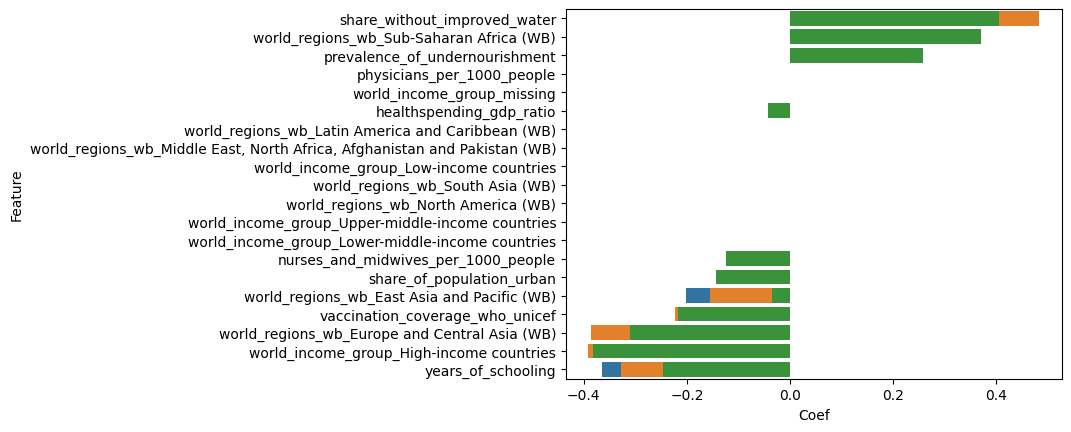

In [291]:
for q, model in qr_models.items():
    qr_pipeline = model.regressor_
    qr_pre = qr_pipeline.named_steps["preprocess"]
    qr_model = qr_pipeline.named_steps["model"]

    #X_qr_transf = qr_pre.transform(X_train)
    X_qr_features = qr_pre.get_feature_names_out()
    qr_coeffs = qr_model.coef_
    coefs_df = pd.DataFrame({"Feature": X_qr_features, "Coef": qr_coeffs}).sort_values(by="Coef", ascending=False)
    print(f"Koeffizienten für Q{q}")
    print(coefs_df)
    sns.barplot(coefs_df, x=coefs_df["Coef"], y=coefs_df["Feature"])